# Algorithm Hierarchical Clustering M

describe

In [1]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class Cluster:
    
    def __init__(self, n):
        ''' '''
        self.n = n # номер класетра (начальной точки)
        self.nodes = set([n]) # объединенные с кластером точки 
        self.join_n  = -1 # номер кластера с которым слит
        self.dist = -1 # расстояние при слиянии (dist <= 0)

    def active(self):
        ''' '''
        return self.join_n == -1
        
    def merge(self, c, dist):
        ''' '''
        self.nodes = self.nodes.union(c.nodes) 
        c.join_n = self.n
        c.dist = np.abs(dist)
        
    def get_n(self):
        ''' '''
        if self.join_n == -1:
            return self.n
        return self.join_n
        
class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
            
    
    def fit(self, x):
        ''' '''
        self._c_all = []
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size): 
            C.append( Cluster(i) )
        
        delta = self.delta
        
        for i in range(self.max_iteration): 
            d = np.min(M[M > 0])  
            #d = self._get_min(M, C) * self.alpha
            if d > delta:
                delta = d  
            delta = delta * self.alpha    
            if(self.debug):   
                print('delta: %.3f, d: %.3f' % (delta, d))    
            M_ = M - delta
            ''' join clusters '''
            join = False
        
            for i in range(size):  
                for j in range(i+1,size):  
                    
                    if(M[i][j] <= 0 or M_[i][j] > 0):
                        continue 
                        
                    if C[i].dist > np.abs(M_[i][j]): 
                        continue
                        
                    a = C[i].get_n()
                    b = C[j].get_n() 
                    if(a == b):
                        continue 
            
                    C[a].merge(C[b], M_[i][j]) 
                    for s in C[b].nodes:
                        #C[s].join_n = a
                        C[a].merge(C[s], M_[i][j])
                    join = True        
            if join == False: 
                delta = delta * self.betta 
                continue
            
            M =   M_ 
                    
            if len(M[M > 0]) == 0:
                break
               
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c.active() == True): 
                    for i in c.nodes:
                        y_[i] = cl
                    cl = cl + 1
                    
            self._c_all.append(y_)  
          
            if len(np.unique(y_)) <= self.n_clusters: 
                break
            neg,pos = [],[]    
            ''' 
            
            
            for i in range(size): 
                for j in range(i,size):
                    if C[i].active() == False:
                        continue
                    if C[j].active() == False:
                        continue
                        
                    if(M[i][j] <= 0):
                        neg.append(np.abs(M[i][j]) + delta)
                    elif(M[i][j] > 0):
                        pos.append(M[i][j])    
            if(self.debug):
                print('Sum pos: %.3f, sum neg: %.3f, Std pos: %.3f, Std neg: %.3f' % 
                      (sum(pos) , sum(neg) ,np.std(pos), np.std(neg))) 
            if np.std(pos) == 0:
                break
            if self.stop_neg_sum and sum(pos) / len(pos) < sum(neg) / len(neg): 
                print('sum(pos) < sum(neg)')
                break 
            '''
            print(np.mean(M[M > 0]), len( np.unique(y_)))
            print(np.std(M[M > 0]), np.std(np.abs(M[M < 0])), np.mean(np.abs(M[M < 0])))
            
        self.labels_ = y_         
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [2]:
v = np.array([[1,1,1,0,0],[0,1,1,1,0]])
print(v)
w = np.where(v == 0)
print(w)

[[1 1 1 0 0]
 [0 1 1 1 0]]
(array([0, 0, 1, 1]), array([3, 4, 0, 4]))


In [57]:
v = np.array([1,2,-1,0])
print(v)
v[v!=0] = v[v!=0] -1
print(v)

[ 1  2 -1  0]
[ 0  1 -2  0]


In [203]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

x1 = np.array([
    [1,1], [1,2], [2,2], [2,1], [5,5],  [6,6], [6,7], [3.5,7], [3.6,7.1], [3.7,6.9], [3.8,6.9] 
]) 

x = np.array([
    [1,1], [1.1,1], [2.1,2], [1.5,2], [10,10], [12,14], [11,12], [11,11],
])

def draw(x, y, fs = (12,12), ax = None, title = None):
    k = 2
    U,s,vh = np.linalg.svd(x) 
    k = min(k, len(s))

    x1 = np.dot(U[:,0:k] * s[0:k], vh[0:k])     

    if(ax is None):
        plt.rcParams["figure.figsize"] = fs
        plt.scatter(x1[:,0], x1[:,1], c=y)
        if(title is not None):
            plt.title(title)
        else:
            plt.title('len y: %d' % len(np.unique(y)))
        return
    ax.scatter(x1[:,0], x1[:,1], c=y)

   

In [204]:
class HC:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
    
    def log(self, msg):
        if(self.debug):
            print(msg)
            
    def print_name(self):
        self.log('HC')
    
    def fit(self, x): 
        ''' '''
        A = euclidean_distances(x,x)
        #print(A)
        self._c_all = []
        C = A.copy()
        labels = [n +1 for n in range(0,len(x))]
        clusters = [set([n]) for n in range(0,len(x))]
        #print(labels)
        n = 1 
        mim_1 = 0
        for i in range(self.max_iteration):
            if len(A[A>0]) == 0:
                self.log("By: len(A[A>0]) == 0")
                break
            mim_ = min(A[A>0]) * self.alpha
            if mim_ > mim_1:
                mim_1 = mim_
            #mim_1   = mim_   
            
            #A = A - mim_1  
            A[(A - mim_1 <= 0) & (A > 0)] = -n
            C = C - mim_1
            w1,w2 = np.where(A == -n) 
            #print(w1)
            #print(w2)
            #print(labels)
            lab= len(np.unique(labels))
            for j in range(0, len(w1)):
                #print((w1[j],w2[j])) !!!
                #labels[w1[j]] = labels[w2[j]] 
                clusters[w1[j]] = clusters[w1[j]].union(clusters[w2[j]])  
                clusters[w2[j]] = set([])
                for k in clusters[w1[j]]:
                    labels[k] = labels[w1[j]]
                #A[w2[j],:]=0
                #A[:,w1[j]]=0
            #print(labels)
            if len(np.unique(labels)) == lab:
                mim_1 = mim_1 * self.betta
                self.log("By: len(np.unique(labels)) == lab: %.6f" % (mim_1))
                continue
            self._c_all.append(labels.copy())
            if(len(np.unique(labels)) <= self.n_clusters):
                self.log("By: len(np.unique(labels)) <= self.n_clusters")
                break
            self.log('min: %.10f, len: %d' % (mim_1, len(np.unique(labels))))     
            #if sum(C[C > 0]) < sum(C[C < 0] * -1):
            #    self.log("By D")
            #    print("By D")
            #    break
            n = n + 1
        #print(labels)
        #print(C)
        self.labels_ = labels
        return labels


In [205]:
hc1 = HC(alpha = 2.0, debug=True)
Y_ = hc1.fit(x)


min: 0.2000000000, len: 7
min: 1.2000000000, len: 4
min: 2.8284271247, len: 2
By: len(np.unique(labels)) == lab: 12.649111
By: len(np.unique(labels)) <= self.n_clusters


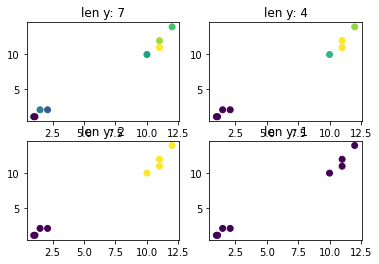

In [206]:
n =-4 
plt.subplot(221)
draw(x, hc1._c_all[n], fs = (10,6))

n =-3 
plt.subplot(222)
draw(x, hc1._c_all[n], fs = (10,6))

n =-2 
plt.subplot(223)
draw(x, hc1._c_all[n], fs = (10,6))

n =-1 
plt.subplot(224)
draw(x, hc1._c_all[n], fs = (10,6))


In [207]:

hc = HC(alpha = 1.05, debug=True)
hc.print_name()
Y_ = hc.fit(x1)


HC
min: 0.1050000000, len: 10
min: 0.1484924240, len: 9
min: 0.2347871376, len: 8
By: len(np.unique(labels)) == lab: 0.593970
By: len(np.unique(labels)) == lab: 1.187939
min: 1.1879393924, len: 4
min: 1.4849242405, len: 3
min: 2.3123851323, len: 2
By: len(np.unique(labels)) == lab: 4.991643
By: len(np.unique(labels)) == lab: 9.983286
By: len(np.unique(labels)) <= self.n_clusters


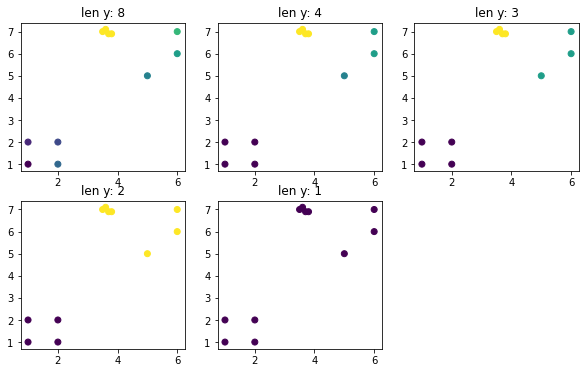

In [210]:
for i in range(0,6):   
    plt.subplot(231+i)
    draw(x1, hc._c_all[i], fs = (15,6))

n =-5
plt.subplot(231)
draw(x1, hc._c_all[n], fs = (10,6))

n =-4
plt.subplot(232)
draw(x1, hc._c_all[n], fs = (10,6))

n =-3 
plt.subplot(233)
draw(x1, hc._c_all[n], fs = (10,6))

n =-2 
plt.subplot(234)
draw(x1, hc._c_all[n], fs = (10,6))

n =-1 
plt.subplot(235)
draw(x1, hc._c_all[n], fs = (10,6))


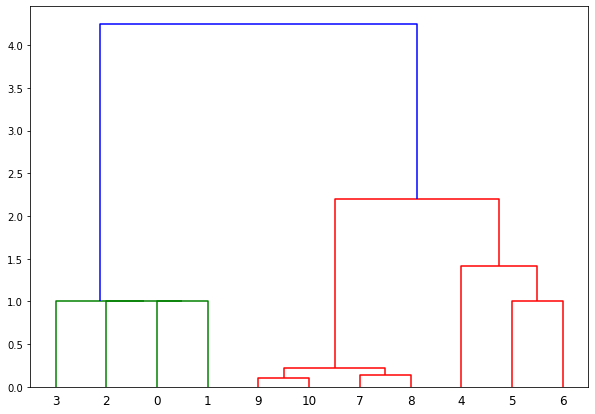

In [128]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(x1, 'single') 
labelList = range(1, len(x1)) 
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
           # labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Text(0.5, 1.0, 'Дерево')

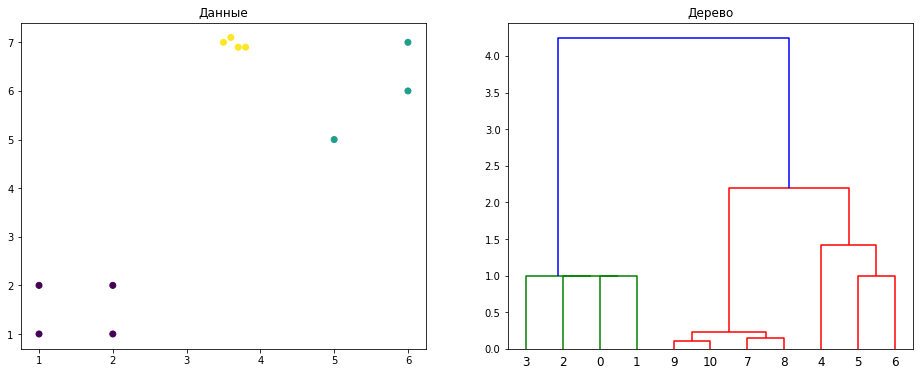

In [190]:
plt.rcParams["figure.figsize"] = (16,6)
np.random.seed(0)

# data
plt.subplot(1, 2, 1)
draw(x1, hc._c_all[-3])
plt.title(u'Данные')


# view
plt.subplot(1, 2, 2)
dendrogram(linked,
            orientation='top',
           # labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.title(u'Дерево')

[  0   0   0   0   0   0   0   1   1   1   1   2   3   3   4   4   4   4
   7   7   7   8   9   9   9   9  10  12  12  17  17  17  17  17  17  19
  19  21  25  27  27  27  27  28  28  28  28  29  29  30  30  30  34  34
  34  34  37  38  39  39  39  39  39  39  40  40  40  45  46  47  47  48
  49  49  57  63  65  69  75  80  80  81  82  88  88  91  92  93  94  95
  95  96  96  96  99  99 112 116 123 126 127 128 132 137 138 139]
[  4   7  17  27  28  39  40   9  12  34  45  47  29  47   0  17  37  40
   0  39  49  38   1  12  30  34  48   1   9   0   4  27  28  39  40  21
  46  19  34   0  17  28  39   0  17  27  39   3  30   9  29  34   1   9
  25  30   4   8   0   7  17  27  28  49   0   4  17   1  19   2   3  10
   7  39  93  91  75  80  65  69  81  80  92  95  96  63  82  57  99  88
  96  88  95  99  94  96 139 137 126 123 138 132 128 116 127 112]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37

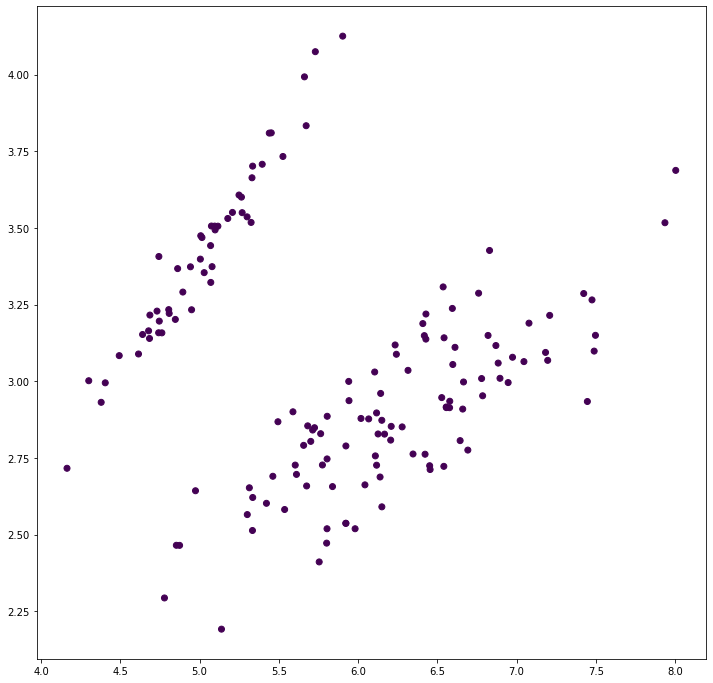

In [130]:
data = load_iris()
ix = data.data
iy = data.target
#cl = HierarchicalClustering(alpha=1.3, debug=1, max_iteration=100)
#iiy = cl.fit(ix)

cl = HC(alpha = 2.0, debug=True)
iiy = cl.fit(ix)

draw(ix,iiy)

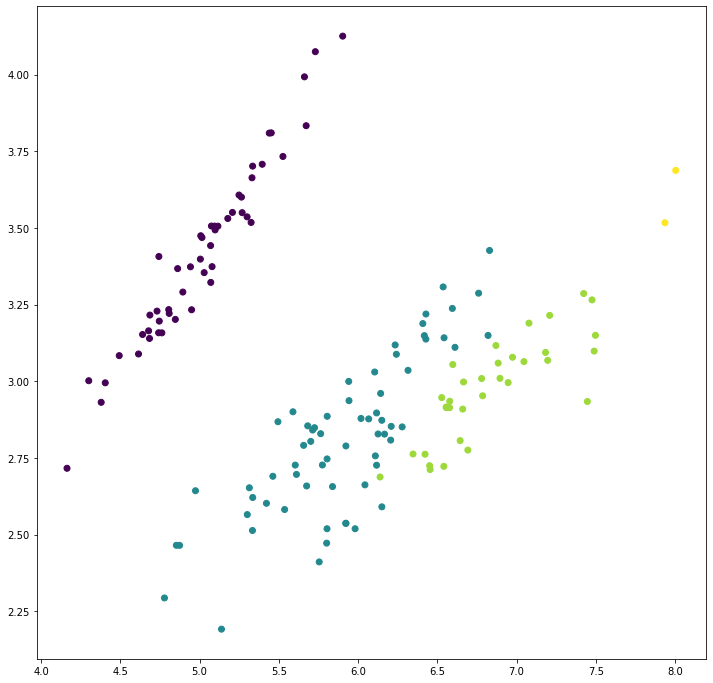

In [133]:
draw(ix,cl._c_all[-3])
#draw(ix, iy)

[ 42 233]
[233  42]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

[ 43 146 147 280]
[147 280  43 146]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 33, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 56, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 70, 93, 79, 95, 96, 97, 45, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 24, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 97, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 35, 192, 193, 194, 195, 196, 197, 138, 199, 200, 201, 202, 203, 204, 9, 206, 207, 75, 209, 210, 211, 212, 213, 214, 215, 21

[  1   7  22  32  34  36  51  54  60  62  93 109 112 156 171 171 181 202
 202 221 229 239 247 256 256 267 283 291 296 296]
[296  51 171 221 109 283   7 202 181 202 296  34 247 256  22 267  60  54
  62  32 291 256 112 156 239 171  36 229   1  93]
[1, 2, 15, 4, 5, 6, 7, 8, 9, 10, 11, 123, 2, 14, 15, 16, 17, 18, 19, 20, 21, 131, 23, 24, 25, 81, 27, 28, 29, 30, 18, 32, 33, 34, 84, 36, 37, 38, 39, 33, 41, 42, 162, 44, 45, 46, 29, 48, 49, 50, 51, 52, 53, 54, 48, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 147, 75, 56, 77, 78, 79, 80, 81, 129, 83, 84, 29, 86, 52, 88, 56, 90, 91, 70, 93, 79, 60, 111, 97, 45, 99, 100, 101, 102, 24, 104, 134, 106, 107, 108, 28, 110, 111, 111, 113, 233, 115, 116, 117, 118, 119, 58, 121, 122, 123, 124, 125, 126, 37, 128, 129, 130, 131, 132, 133, 134, 135, 136, 83, 138, 139, 140, 141, 142, 143, 144, 111, 24, 147, 44, 16, 150, 151, 15, 153, 154, 155, 162, 157, 158, 29, 97, 161, 162, 141, 164, 45, 139, 12, 168, 169, 170, 171, 172, 173, 174

[  2   3   3   5   9  11  11  11  12  17  17  17  18  19  19  21  21  23
  24  24  25  25  40  43  48  49  50  50  52  57  61  68  68  69  71  71
  75  77  77  77  78  80  84  89  91  92  93  96  96 100 103 105 105 116
 118 119 121 123 124 124 125 125 126 127 129 130 133 133 135 136 140 140
 146 148 148 148 149 151 151 153 153 155 156 159 159 161 164 166 170 171
 175 178 178 179 179 182 186 189 189 191 192 194 196 197 198 201 205 207
 209 211 211 212 213 215 216 218 220 222 224 225 226 227 228 229 230 231
 232 234 237 240 248 250 250 251 254 254 256 261 261 271 272 274 274 275
 281 281 286 289 294 295 298 299]
[ 68  24 175  61 125  57 119 140  93 189 196 232  71 116 240 198 274 171
   3 105 118 226 105 254 129 298 133 148 126  11   5   2 140 179  18  89
 228  96 159 215 294 194 170  71 179 229  12  77 237 234 281  24  40  19
  25  11 211 256 161 250   9 248  52 286  48 159  50 148 216 218  11  68
 209  50 133 222 182 166 251 186 201 213 164  77 130 124 156 151  84  23
   3 231 295  69 

[57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,

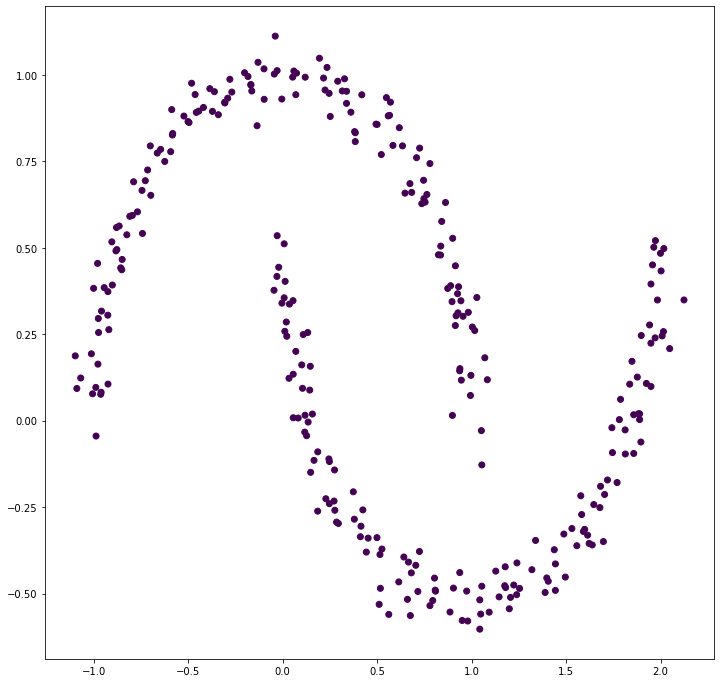

In [134]:
# noisy_moons
from sklearn import cluster, datasets, mixture
mx,my =  datasets.make_moons(n_samples=300, noise=.05)

#cl2 = HierarchicalClustering(alpha=1., debug=1)
#mmy = cl2.fit(mx)
cl2 = HC(alpha = 1.06, debug=False, max_iteration=300)
mmy = cl2.fit(mx)
draw(mx,mmy)

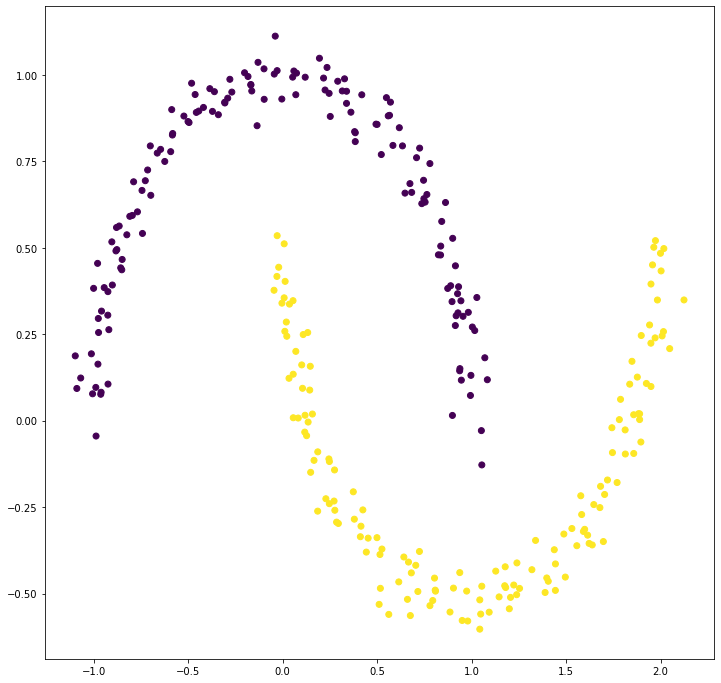

In [135]:
n = -2
#print(cl2._c_all[n])
draw(mx,cl2._c_all[n])

[569 773]
[773 569]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

[ 542 1380]
[1380  542]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217

[ 834 1061 1212 1431]
[1061  834 1431 1212]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

[ 382  641 1064 1228 1269 1463]
[1269 1228 1463  641  382 1064]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209

[321 638 987 994]
[638 321 994 987]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 2

[ 881  924  982 1154]
[1154  982  924  881]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

[ 464 1104 1219 1279]
[1104  464 1279 1219]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

[  23 1061 1147 1469]
[1147 1469   23 1061]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

[  66  322  381  611  806  886  972 1209 1219 1499]
[1499  806  611  381  322 1209 1219  886  972   66]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201

[ 469 1158 1339 1341]
[1158  469 1341 1339]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

[ 262  582  779  845  977 1108]
[ 977  845 1108  582  262  779]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209

[ 208  415  463  834  980 1042 1100 1469]
[1100  463  415 1469 1042  980  208  834]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205

[ 283  673  783  819 1044 1243 1285 1506]
[ 783 1243  283 1506 1285  673 1044  819]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205

[  46  255 1134 1309]
[ 255   46 1309 1134]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

[ 281  401  543  915 1019 1216 1248 1413 1418 1526]
[ 915 1413 1526  281 1248 1418 1019  401 1216  543]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201

[  13   39  166  242  496  573  594  612  681  972 1174 1279 1458 1524]
[ 594  573 1174 1524  612   39   13  496 1458 1279  166  972  681  242]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193

[  56  100  428  434 1271 1280]
[1271  434 1280  100   56  428]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209

[ 106  153  333  619 1330 1462 1495 1515]
[1330  333  153 1462  106  619 1515 1495]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205

[   2   49   68  128  214  480  533  681  852  886  998 1097 1117 1260]
[1260  480  998  533  852   49  128 1097  214 1117   68  681  886    2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193

[ 130  329  353  447  486  488  511  625  636  656  684  888 1113 1157
 1174 1324]
[ 625 1324  636  656 1157  888 1174  130  353  447 1113  488  684  486
  511  329]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 1

[  19   25   92  233  451  517  603  873  953  965 1134 1162 1362 1451]
[ 233  517  603   19 1134   25   92 1162 1451 1362  451  873  965  953]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 512, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193

[ 465 1117 1122 1209 1436 1438 1464 1490]
[1438 1209 1436 1117 1122  465 1490 1464]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 512, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205

[  73  282  296  312  399  598  667  897  922 1001 1036 1102 1131 1389
 1448 1464]
[ 922  598 1102  399  312  282 1036 1001   73  897  667  296 1448 1464
 1131 1389]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 512, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 1

[  33  113  149  195  229  326  357  633  689  701  761  776  780  899
  921  960  964 1041 1121 1477]
[ 113   33  964  689  357  780  229  701  195  633 1121 1041  326 1477
  960  921  149  776  761  899]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 512, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

[  42   48   98  131  195  311  453  474  584  626  657  659  696  750
  763  767  784  819  944 1050 1073 1112 1142 1142 1233 1266 1424 1492]
[ 784  819  659 1424 1112  453  311 1142 1073 1050  750   98  944  657
 1492 1142   42   48  696  626  584  195  474  767 1266 1233  131  763]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 16

[  26  145  152  192  243  357  405  418  536  609  617  733  801  816
  848 1000 1008 1072 1318 1487 1501 1516]
[ 848 1318 1487  816 1501  733 1008 1072 1516 1000  801  357  617  192
   26  609  405  418  145  152  243  536]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 512, 168, 169, 170, 171, 172, 173, 174, 175, 176, 1

[   6   48  140  143  148  400  472  503  529  597  652  732  822  846
  949  967  972 1046 1129 1334 1413 1451 1461 1506]
[ 400 1506  967 1413  472    6  148  732  822 1334 1046  503  529 1129
  972  140  949  652  846  597  143 1461 1451   48]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 512, 168, 169, 170, 171, 172, 1

[  47   81  143  166  201  292  293  345  374  401  497  511  511  645
  647  759  940  960  970 1004 1054 1078 1097 1149 1151 1242 1358 1390
 1407 1458 1484 1484]
[1151  497  401  511  345 1484 1484  201  645  143   81  166 1358  374
 1078 1390  970 1407  940 1054 1004  647 1458 1242   47 1149  511  759
  960 1097  292  293]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,

[  75  275  280  286  418  420  479  490  493  499  513  696  702  747
  754  772  786  787  801  851  880  905 1006 1234 1238 1270 1320 1378
 1419 1472]
[ 499  786  702 1472 1320  787  490  479 1378   75 1234  747  280  696
  905 1419  275  420 1006 1238 1270  754  801  513  851  880  418  493
  772  286]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,

[  37   44   96  120  135  162  181  193  196  292  324  377  384  396
  632  685  689  716  726  728  855  924  956  982 1077 1112 1128 1209
 1225 1230 1287 1374 1437 1442 1442 1446]
[1230 1374 1225  716  632 1209  292  685  396  181 1077 1128 1287  196
  135  193 1112  120  728  726 1446 1442 1437 1442  324  689  377  162
   96   37  384   44  956  924  982  855]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,

[   3   86   95  100  121  152  157  172  179  209  229  230  253  265
  298  334  383  426  451  459  506  544  548  555  564  576  588  590
  604  714  724  733  735  865  949 1193 1205 1206 1219 1267 1309 1340
 1345 1349 1451 1497]
[1206  735  383  172 1349  564  179  100  157 1205  733 1193  459  724
  865  426   95  334 1309  253 1340  548  544 1497  152  588  576  714
 1267  590  265  229   86  298 1219  230  209    3  949  604  451  506
 1451  121 1345  555]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 12

[   1    8   30  109  185  232  301  322  340  352  411  438  445  462
  469  474  479  486  517  521  551  565  614  635  637  654  715  731
  733  767  888  905  959  976  985 1072 1075 1086 1161 1164 1194 1241
 1242 1284 1293 1301 1306 1320 1365 1393 1403 1483]
[ 985 1242  637  445  232  185  715  733  479 1284 1194 1086  109  654
  486  767  340  469  905  565  959  521 1306  731   30  462  301  635
  322  474 1164  517  551 1483    1 1320 1293  438 1393  888  411 1403
    8  352 1075 1365  614 1072 1301 1161 1241  976]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 115, 11

[  20   31   46   72   75  136  185  220  228  251  273  301  303  343
  364  381  476  476  482  501  512  584  611  634  697  715  755  757
  767  783  795  899  916  953  959  979 1087 1111 1138 1144 1186 1212
 1222 1281 1288 1292 1309 1335 1345 1364 1364 1381 1393 1399 1399 1421
 1464 1469]
[ 634 1281 1288  783 1144  220 1292  136  584 1309 1111 1364  476  767
  501 1399  303 1087  959  364  979  228 1399   20  916 1364 1335 1421
  343   72  899  795  697 1345  482  512  476  273 1222   75 1469 1393
 1138   31   46  185  251  755  953  301  715 1464 1212  381  611  757
 1381 1186]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,

[  15   34  101  105  113  114  119  137  162  164  180  219  244  252
  305  336  339  343  382  470  488  499  504  517  564  628  649  702
  792  810  810  829  835  886  886  949  991 1000 1077 1089 1131 1142
 1157 1164 1202 1217 1243 1269 1279 1289 1296 1340 1381 1389 1393 1410
 1411 1431 1442 1450]
[ 114 1243  628 1450  835   15  792  829  886 1410  470 1411 1202  564
  336  305 1217 1142  810  180 1164  991  649  886  252  101  504 1442
  119  382 1269  137  113  162  517 1279  499 1077 1000 1296 1289  343
 1340  488  244  339   34  810  949 1131 1089 1157 1389 1381 1431  164
  219 1393  702  105]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,

[  16   49   57  108  133  161  191  198  213  224  253  259  314  330
  362  486  492  498  528  577  651  659  688  730  733  787  806  855
  866  930  953  970 1018 1027 1078 1095 1096 1096 1158 1184 1229 1234
 1269 1318 1319 1320 1385 1403 1417 1446 1472 1498]
[1472  970 1318  213 1417 1229 1320 1095  108 1027 1403  787  577  528
 1498 1158  953 1078  330  314  730 1385  866  651  806  259  733 1096
  688 1319  492   49 1184  224  498  198  855 1446  486 1018  161 1269
 1234   57  930  191  659  253  133 1096   16  362]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 34, 16, 116

[  22   47   89  132  148  164  165  194  226  303  308  315  361  363
  385  391  394  412  414  481  485  528  557  587  588  592  632  641
  675  703  717  740  749  750  754  771  778  796  821  824  854  872
  877  926  979 1041 1043 1061 1073 1093 1110 1110 1128 1138 1167 1186
 1213 1249 1323 1333 1381 1389 1429 1432 1441 1476 1483 1490 1513 1526]
[ 854  363 1432  749  703 1213  821  394  796 1333  926 1526  877   47
 1381 1429  194  717 1483  740 1441 1513 1093 1167  641  979 1073  588
  771  148  412  481  132 1138 1043  675 1041  226  165  872   22  824
  361  308  592  778  754 1186  632  557 1128 1476 1110  750  587 1061
  164 1323 1249  303  385 1490  391   89  485 1110  414 1389  528  315]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,

[   9   27   37   42   43   46   59   67   72  107  109  117  119  122
  153  181  187  203  214  220  235  240  277  283  317  330  382  419
  459  477  481  486  507  517  539  568  574  588  598  628  651  682
  743  763  790  837  845  919  947  953  966  967 1019 1143 1161 1189
 1196 1209 1228 1234 1237 1240 1251 1308 1308 1340 1380 1381 1388 1402
 1417 1440 1461 1468 1484 1490]
[ 919 1468 1251  119  763  481  317  598  283  277 1143  203   42  967
 1308 1484 1417  117  539  966  477 1189  107   72   59  507 1234 1237
  682  235   46 1340  330 1209  214 1380 1240 1228   67 1388 1196  459
 1440   43 1161 1402 1308    9 1019 1461  220  122  947  109  790  240
  651  517  588  382  419  574   37  153  845  486  568 1490  628  837
  187  743  953   27  181 1381]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5

[  32   45   58   59   90  109  136  171  172  231  255  255  282  300
  305  306  308  323  400  404  434  456  460  469  481  492  527  585
  594  607  618  630  650  706  712  747  834  843  909  944  948  972
  989  994 1053 1094 1103 1127 1157 1158 1161 1170 1174 1186 1186 1266
 1288 1290 1345 1358 1391 1408 1420 1435 1451 1455 1461 1497 1510 1516]
[ 231 1290 1053  948 1391  994  607  305  434   32  481 1288 1497 1094
  171 1103 1266  712  585  843  172  630 1186 1157  255 1451  650  400
 1161  136  909  456  527 1516  323  944 1186  404  618  747   59 1127
 1170  109   58  300  306  972  469 1510  594  989 1358  460  834  308
  255   45 1461 1174   90 1455 1435 1420  492 1408 1345  282 1158  706]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 764, 45, 46, 47, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74

[  22   25   25   27   67   75   98  114  251  264  282  299  329  368
  392  392  405  431  441  445  445  457  460  507  528  533  540  542
  548  568  577  585  585  596  671  672  736  740  756  763  823  829
  839  886  905  921  942  944  955  987  991  994 1021 1046 1087 1102
 1124 1134 1139 1143 1157 1158 1192 1253 1276 1286 1288 1315 1333 1385
 1407 1421 1433 1469]
[ 299  886  905  540  282  991 1385 1333 1134  392   67   22  671  431
  264  533 1046  368  823  987  994 1286 1469  528  507  392   27  568
 1102  542  596  829 1139  577  329 1276 1433 1288 1143 1421  441  585
 1315   25   25 1407 1124 1021 1087  445   75  445  944  405  955  548
  942  251  585  756 1158 1157 1253 1192  672  457  740  839  114   98
  921  763  736  460]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1213, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 764, 45, 46, 482, 48, 820, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6

[   7    9   12   34   48   49   57   76  109  112  125  145  162  195
  199  221  239  269  288  292  293  300  315  317  368  374  385  390
  420  433  472  480  503  517  519  536  543  582  626  648  661  666
  667  673  696  703  706  748  755  776  778  795  800  844  845  876
  885  916  935  940  940  948  955  970  977  987 1017 1021 1062 1062
 1107 1117 1117 1127 1146 1176 1200 1218 1219 1226 1246 1263 1268 1282
 1308 1318 1334 1410 1437 1456 1477 1488]
[ 916 1017  288  673 1218  940  145  648  987  626  374   57 1117 1146
  503 1226  519 1334   12  293  292  755  543  948  940  125  845  885
  800  955  703  970  199 1117  239  706  315 1308  112   76  666  661
 1062   34 1021  472  536 1488  300  778  776 1477  420 1107  385 1246
  390    7 1176   49  368  317  433  480 1437  109    9  696  667 1456
  844  162  517 1219  195  935 1318   48 1127  221  876 1282 1410 1263
  582 1200  269 1268  977 1062  795  748]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1213, 15, 16, 17, 18

[   8   12   15   21   25   57   65   83  101  128  141  145  166  181
  204  222  224  241  243  247  269  284  293  322  332  351  357  378
  385  392  398  460  498  510  515  531  534  534  545  591  597  602
  617  647  666  700  756  779  806  812  815  825  879  896  905  911
  955  971  991 1006 1035 1038 1043 1061 1090 1114 1127 1144 1149 1200
 1204 1208 1209 1257 1268 1279 1286 1325 1328 1329 1333 1334 1351 1358
 1388 1389 1390 1407 1421 1423 1426 1439 1461 1489 1492 1520]
[1149 1423 1333   83 1209  591 1390   21 1388  392 1439 1200 1358  293
  806 1334 1090  515 1426  879  597 1038  181  357  510  911  322  815
 1389  128 1407 1061  647  332  241  812 1325 1329  825   57  269  700
 1006  498 1351  602 1035 1328  204  531  378  545  247  971 1043  351
 1208  896 1144  617  756  284  905  460  224 1286 1279  991    8  145
 1520  955   25 1489 1461 1127 1114  534  779  534   15  222  666  166
  101  385   65  398 1492   12  243  141 1268 1257 1421 1204]
[1, 2, 3, 4, 5, 6, 7, 8,

[  13   14   18   24   25   26   95  154  158  162  171  191  217  220
  228  262  280  294  296  296  298  300  309  324  329  336  338  338
  340  345  357  358  380  385  390  399  407  408  414  418  444  446
  452  460  464  469  482  488  490  490  499  500  542  548  551  564
  572  576  582  586  606  606  645  648  648  649  651  653  656  677
  711  717  723  732  743  777  785  788  810  812  819  832  834  836
  857  866  873  914  914  919  920  947  957  976  992  998 1000 1002
 1007 1017 1050 1073 1079 1083 1084 1095 1104 1108 1121 1126 1130 1144
 1159 1161 1192 1196 1218 1220 1223 1237 1248 1248 1259 1289 1295 1303
 1306 1321 1323 1327 1328 1335 1364 1374 1399 1437 1442 1448 1450 1454
 1475 1476 1482 1485 1487 1502 1510 1515]
[1161  914 1130 1454  162 1475 1223  542  500   25  336  418  857  452
 1073 1437 1442  296  294  649 1399 1335  408 1000  653  171  464 1104
  490 1007 1485 1482 1321  582  399  390  490  309  976  191 1083 1220
  220  834  338 1510  551 1050  340

[  13   16   39   44   48   65   73   83  117  120  122  126  140  154
  162  186  212  217  219  228  231  244  258  259  283  286  312  330
  333  335  335  342  343  351  356  359  362  368  390  391  400  405
  420  454  474  481  492  517  539  555  573  593  594  604  606  607
  608  609  617  623  639  640  641  652  658  675  698  715  719  722
  724  750  759  761  772  774  790  828  829  850  852  861  894  919
  927  928  949  974  999 1002 1002 1040 1077 1085 1094 1127 1160 1161
 1181 1222 1235 1246 1249 1250 1288 1308 1327 1343 1347 1353 1356 1356
 1380 1393 1394 1397 1431 1445 1452 1460 1461 1470 1490 1495 1496 1513]
[  73  286  623  606  244  759   13  927  675 1356  140 1496  122 1380
  517 1452  658 1094 1181  454  593   48 1160  420 1470   16  390 1513
 1308  919 1490 1445  474 1353  359  356  617  861  312 1235  829  652
  259  228  343 1288 1461  162  852  639  928  231  790 1250   44 1356
 1397 1077  362   39  555 1085 1249  405  212  117 1393  724 1002 1495
  715

[  33   46   64   71   80   81   86  102  125  127  130  152  159  161
  166  178  201  204  210  252  274  279  289  294  298  303  308  322
  355  357  385  393  395  446  448  466  509  511  512  519  540  544
  544  584  588  601  604  610  616  628  630  632  647  669  671  674
  682  694  721  730  732  740  767  776  787  795  800  806  808  810
  835  886  901  905  908  917  928  936  938  944  984 1004 1007 1010
 1019 1030 1033 1033 1033 1034 1049 1063 1077 1087 1106 1112 1146 1159
 1161 1165 1167 1173 1182 1190 1202 1212 1221 1233 1234 1259 1283 1308
 1358 1359 1385 1394 1409 1412 1419 1422 1426 1434 1441 1444 1459 1468
 1468 1495 1501 1502 1513 1513]
[ 835  740  519  279  512  210  289 1422  944  936  509  252  393  588
 1033 1459 1007  322   81  152  808   71   86  730  601 1087 1233  204
 1010  806 1308  159 1434  669 1159  544  130 1033   80   64 1468  466
 1259  632  161  298  795 1106 1412  682  674  584  908  446 1394  630
  628  767 1359  294 1495   46  694  928  800

[   4    5    6    8   11   15   18   25   34   42   43   60   69   94
  101  119  128  133  135  138  151  182  187  198  199  203  207  210
  229  229  244  251  253  285  288  303  322  329  344  355  398  421
  441  443  451  459  467  472  476  480  484  486  491  500  501  504
  505  506  506  513  517  533  554  567  583  585  596  650  653  657
  665  671  688  691  702  702  702  719  732  754  758  778  784  792
  808  824  828  831  839  844  848  877  878  880  884  905  911  921
  923  924  927  928  940  943  945  947  958  960  977  982  982  993
  995 1010 1010 1017 1045 1049 1053 1073 1074 1101 1117 1117 1129 1132
 1138 1140 1149 1150 1157 1166 1195 1228 1231 1241 1249 1263 1269 1270
 1273 1285 1293 1324 1324 1331 1333 1333 1337 1343 1361 1378 1394 1403
 1408 1413 1415 1422 1422 1423 1439 1463 1475 1486 1492 1513]
[ 421  484  585  355 1408  303  500 1117 1053  792 1492 1331   94   69
  719  784 1017  187 1073  665  505  229  133  688  732 1150  596  947
  182  322 1513

[   1   31   32   34   39   58   98  102  126  136  148  148  151  160
  193  198  232  241  244  262  271  277  281  282  294  296  309  316
  324  332  342  348  350  363  369  374  382  383  385  391  394  395
  400  411  424  433  433  433  452  454  463  475  478  487  497  505
  507  509  513  522  523  534  539  546  548  555  574  576  583  593
  598  609  625  639  641  645  652  653  671  673  680  717  730  742
  761  771  772  777  790  820  846  850  866  869  872  880  888  893
  905  906  911  915  928  936  946  950  955  958  964  976  988  991
  993 1008 1008 1023 1029 1033 1033 1033 1036 1036 1038 1043 1044 1050
 1062 1063 1064 1072 1102 1111 1114 1119 1127 1133 1139 1144 1144 1151
 1163 1174 1196 1198 1208 1209 1217 1218 1223 1232 1234 1259 1264 1266
 1267 1273 1274 1277 1280 1282 1290 1292 1303 1312 1347 1350 1352 1353
 1358 1363 1378 1393 1411 1415 1435 1440 1446 1450 1464 1465 1480 1492
 1493 1497 1506 1506]
[ 316 1352  593   58  928   34  761  880 1163  452  946

[   4    6    9   13   26   31   65   68   69   71   73   76   83   84
   95   99  104  108  112  114  114  127  129  129  135  141  150  151
  162  187  190  191  192  205  213  225  228  229  242  247  255  256
  269  280  285  291  303  308  314  319  319  328  334  335  335  338
  351  372  377  391  412  412  415  419  421  425  428  431  445  447
  458  476  478  492  502  512  513  530  546  563  571  573  576  576
  581  581  588  588  592  594  596  602  613  623  635  643  649  656
  661  688  689  703  722  728  733  740  742  747  751  762  783  790
  790  794  794  806  808  822  832  833  835  851  857  860  861  868
  875  878  892  917  924  924  927  935  943  946  957  957  998 1000
 1006 1009 1017 1038 1044 1045 1047 1050 1052 1054 1072 1075 1084 1090
 1102 1107 1110 1114 1123 1127 1133 1146 1146 1148 1157 1164 1166 1169
 1188 1190 1202 1208 1213 1218 1222 1228 1230 1249 1249 1251 1254 1261
 1279 1303 1307 1315 1323 1324 1324 1325 1345 1351 1359 1360 1361 1369
 1372 

[   6    9   10   21   58   63   76   76  104  107  117  125  126  136
  150  151  151  172  173  206  229  244  250  253  265  270  280  287
  299  308  328  352  355  367  384  401  407  441  445  455  458  474
  486  493  513  546  555  582  582  582  601  604  613  615  634  639
  645  682  687  688  691  698  724  726  734  755  758  772  777  788
  790  810  811  819  819  823  825  826  844  845  854  860  863  865
  868  877  885  888  893  899  927  928  947  966  971  978  978  990
  991 1008 1016 1041 1046 1057 1065 1087 1095 1096 1115 1133 1138 1139
 1143 1149 1150 1162 1173 1182 1193 1195 1195 1205 1210 1212 1212 1213
 1213 1214 1221 1223 1232 1238 1243 1244 1252 1255 1257 1262 1267 1285
 1319 1326 1346 1369 1372 1379 1379 1388 1389 1389 1397 1401 1410 1457
 1463 1485 1490 1493 1506 1510 1518 1524]
[1139 1490  206  927 1243 1346  687 1210 1195 1493 1150  645 1238  966
  811 1087 1133  458  287   10 1485  819 1397  682 1379 1205  844  173
  854  555  893  615 1149  788  758

[   7    7    9   13   18   25   29   54   68   77   81   82   97   98
   99  109  114  117  128  131  134  137  146  149  149  151  155  156
  161  164  189  203  208  209  210  220  222  244  252  268  271  280
  286  288  290  299  303  309  310  310  330  335  338  354  355  364
  365  368  384  394  412  412  423  432  433  434  443  457  466  469
  469  474  488  495  503  513  533  533  544  548  555  576  585  594
  597  603  603  606  607  618  626  629  643  655  657  668  670  691
  691  694  697  698  717  721  732  737  747  754  756  757  758  795
  808  819  819  826  826  841  841  845  845  854  869  888  888  899
  906  906  922  926  934  941  949  956  970  977  982  988 1006 1009
 1010 1016 1017 1017 1019 1021 1027 1036 1058 1066 1068 1073 1073 1086
 1090 1096 1098 1102 1109 1111 1114 1119 1121 1128 1129 1137 1142 1144
 1149 1158 1163 1191 1196 1196 1197 1217 1219 1222 1225 1235 1239 1240
 1243 1246 1250 1255 1257 1262 1266 1267 1268 1281 1287 1288 1303 1303
 1308 

[   1    5    8   11   11   14   15   20   29   36   43   58   62   64
   75   75  105  120  123  125  128  137  146  155  161  183  199  204
  210  211  213  216  222  223  230  230  232  242  271  289  291  293
  294  298  299  303  307  315  322  342  343  353  355  355  362  363
  366  374  385  392  394  396  398  398  406  406  408  421  432  433
  452  456  469  475  476  482  488  493  497  502  505  505  510  515
  517  522  532  534  539  545  552  554  555  563  575  576  581  611
  615  632  637  641  651  652  652  659  667  673  674  694  694  696
  698  702  709  720  721  723  723  730  731  733  735  754  754  757
  761  763  784  785  786  791  792  801  810  811  816  816  818  831
  835  839  854  858  863  869  878  886  904  918  919  921  935  941
  941  947  955  957  964  966  976  992  993  994 1008 1009 1017 1023
 1041 1043 1045 1057 1064 1065 1066 1092 1097 1100 1104 1107 1113 1116
 1117 1122 1142 1143 1158 1158 1161 1162 1164 1182 1196 1214 1217 1228
 1230 

[   6    9   13   30   54   66   67   68   69   69   69   72   94   96
  103  106  133  135  143  144  145  150  151  153  153  158  161  164
  182  182  183  194  216  223  228  236  239  261  262  265  266  268
  271  273  273  273  273  275  276  289  298  299  318  326  329  330
  330  334  338  342  342  342  357  381  389  393  393  395  396  398
  407  419  424  425  441  447  452  454  466  476  479  488  499  503
  503  507  511  518  526  549  571  581  581  581  582  584  584  584
  587  591  591  592  594  600  601  604  607  611  613  614  618  621
  623  632  633  636  639  641  646  649  667  682  706  708  715  715
  716  719  724  725  726  732  734  742  751  757  758  758  763  780
  795  806  811  812  824  829  841  845  845  846  846  848  850  865
  868  868  874  880  890  893  899  900  908  914  922  926  937  948
  950  956  960  964  972  980  985  987  987  988  989  999 1002 1013
 1020 1032 1044 1056 1064 1067 1071 1076 1078 1102 1104 1116 1122 1123
 1129 

[   6   15   17   25   25   25   35   35   48   57   61   66   66   66
   74   83  100  102  112  116  125  125  135  144  154  154  160  162
  164  165  168  178  182  188  196  199  210  213  214  215  219  240
  244  252  254  254  265  275  279  281  284  285  296  301  301  310
  310  316  322  324  328  333  334  335  359  361  369  369  369  373
  382  395  405  405  418  419  422  428  433  436  452  454  461  464
  464  467  471  472  481  488  497  497  498  499  504  513  527  528
  529  530  539  539  555  568  582  584  589  598  598  601  617  626
  632  634  639  647  648  653  659  667  675  680  684  687  688  708
  709  710  715  715  721  722  723  723  723  724  724  725  728  732
  733  736  740  740  747  751  754  754  773  774  776  776  786  801
  802  806  810  817  830  833  834  839  839  844  854  860  861  865
  866  868  868  872  873  888  892  901  902  905  907  908  910  913
  915  917  929  932  934  939  940  946  950  961  961  961  965  966
  966 

[   1    2    3    4    8    9   10   15   20   22   22   29   31   37
   48   49   56   62   63   66   66   67   68   73   75   80   81   81
   81   85   92   93   98  100  101  112  117  126  128  133  133  136
  137  139  144  153  153  153  154  157  164  177  183  184  184  189
  193  194  196  196  204  206  210  212  222  227  227  230  230  232
  237  240  241  242  245  246  247  264  264  267  269  270  284  288
  291  293  294  298  299  308  316  319  331  339  340  342  347  355
  355  368  370  373  374  376  380  381  382  384  385  389  389  394
  394  400  407  414  419  423  431  434  448  452  452  454  458  459
  461  464  466  467  469  469  470  484  484  485  488  488  492  497
  501  506  507  512  513  521  528  529  533  543  546  551  555  565
  569  582  582  584  591  595  601  604  604  609  611  615  626  635
  636  639  639  649  651  651  657  657  658  669  680  681  685  687
  689  692  696  707  708  709  711  712  716  719  720  722  731  744
  744 

[   6    7    9   13   14   15   15   17   23   37   39   41   43   44
   48   48   48   57   64   75   76   77   78   81   83   84   92  101
  105  110  110  111  113  120  125  128  132  133  138  141  144  145
  146  146  149  151  158  160  162  162  166  179  194  194  194  199
  203  205  206  208  209  210  215  220  232  233  242  244  254  259
  259  264  266  267  270  271  271  286  288  293  293  294  296  303
  306  309  312  313  315  319  323  330  330  332  333  335  339  339
  340  342  347  348  350  353  358  358  366  374  377  377  378  381
  383  392  395  399  400  424  425  426  433  434  438  445  452  454
  455  464  464  475  476  478  485  486  490  492  493  496  499  500
  512  516  521  521  523  523  527  528  529  530  531  533  539  541
  544  546  548  565  568  581  582  588  591  597  600  601  601  604
  606  607  607  614  617  626  628  635  640  641  649  651  659  667
  673  675  680  682  693  694  700  707  707  714  717  719  721  722
  723 

[   3    6    6    9    9    9   11   18   20   22   23   27   30   30
   36   39   45   46   48   56   56   64   66   66   66   67   80   83
   84   87   90   92  102  106  108  109  112  112  114  121  125  126
  128  128  133  135  135  135  137  138  141  141  149  153  158  159
  161  164  166  172  179  181  185  185  192  196  202  204  206  209
  213  217  217  225  230  233  237  239  244  251  254  259  261  270
  270  270  271  278  280  281  281  289  291  296  300  301  315  324
  324  326  329  330  333  334  339  343  344  349  353  357  358  362
  362  373  379  382  382  397  398  402  407  408  408  411  414  419
  419  424  425  426  434  434  436  439  442  447  448  448  458  459
  460  479  482  483  488  500  503  504  504  506  514  514  516  517
  518  519  522  531  543  554  555  563  565  569  573  573  585  588
  594  594  601  613  614  616  623  628  632  637  637  641  646  647
  649  653  661  671  673  681  682  687  691  691  694  700  700  703
  706 

[   3   10   12   12   14   15   19   20   20   22   25   29   29   33
   36   39   43   43   48   49   51   54   54   55   57   64   64   64
   68   81   82   89   92  100  100  100  101  104  105  107  108  111
  113  114  114  125  126  129  129  132  135  135  135  137  139  142
  144  145  146  151  153  154  159  159  161  162  166  171  172  177
  177  186  186  194  195  202  204  205  207  210  213  216  217  220
  225  229  230  237  239  254  254  254  254  255  257  265  274  277
  282  285  287  301  314  320  321  327  330  331  331  333  333  333
  335  338  340  340  341  342  348  348  349  349  350  351  352  362
  367  368  369  370  374  374  382  385  396  396  400  402  406  407
  408  413  414  415  423  424  426  433  448  449  452  452  462  463
  464  466  476  480  483  490  495  497  499  499  503  505  505  508
  511  517  519  520  520  522  527  527  528  533  539  542  545  550
  571  576  577  580  582  582  583  586  589  591  591  593  594  597
  597 

[   9    9   13   13   13   15   16   16   21   23   24   24   30   34
   38   38   39   45   46   47   48   51   58   58   64   69   73   73
   74   74   75   75   81   82   89  103  104  105  105  105  109  112
  112  120  126  133  135  135  136  140  141  142  150  153  154  159
  162  162  162  164  172  173  175  183  184  193  194  194  194  208
  210  212  214  215  216  222  224  226  227  227  228  228  228  237
  240  241  244  246  255  255  257  259  265  265  266  267  274  275
  276  282  282  285  294  294  294  294  296  296  296  299  299  300
  301  301  302  303  308  309  309  316  328  329  331  333  335  336
  338  339  340  342  342  348  348  351  354  361  364  374  377  381
  385  388  389  389  390  391  392  392  393  394  402  402  402  405
  407  408  408  411  412  415  419  419  436  438  438  441  442  445
  447  454  463  463  464  466  467  470  471  483  483  486  487  488
  491  498  499  500  504  505  505  507  507  511  513  515  528  529
  531 

[   1    1    1    6    6    7    8    9   13   14   15   15   19   20
   22   22   26   26   36   37   39   46   48   51   58   59   62   63
   67   67   69   73   74   75   77   77   80   83   84   93   94   95
   96   98   98   98   99   99  100  102  110  133  137  137  138  140
  145  147  149  150  151  152  158  160  160  166  166  167  172  177
  180  180  181  181  181  182  182  185  185  187  187  192  193  195
  198  199  207  208  214  214  216  218  219  220  220  228  232  244
  244  246  246  246  251  252  262  265  269  280  287  292  296  297
  298  300  302  314  317  322  322  323  324  326  329  330  330  331
  331  333  333  339  339  342  344  348  348  353  362  363  377  378
  381  381  382  386  388  392  394  394  401  402  402  407  409  412
  412  414  414  415  415  415  424  424  425  430  431  433  434  439
  446  451  455  460  463  463  466  466  466  474  476  479  480  481
  482  486  490  496  497  499  503  506  507  508  511  515  518  521
  524 

[   1    2    6    7    8    8    8   11   19   19   21   21   22   25
   25   27   35   36   39   46   46   49   57   57   57   62   63   63
   64   67   73   84   94   96   98   99  101  104  105  108  108  110
  110  110  112  112  114  114  120  123  125  127  127  128  133  135
  136  137  143  149  150  151  154  156  157  158  161  162  162  164
  168  171  173  180  181  185  185  187  192  192  194  195  195  196
  209  214  218  220  233  237  240  241  242  246  247  255  255  257
  263  264  264  267  268  269  270  271  273  274  280  281  282  282
  287  292  292  292  292  292  293  294  299  300  302  303  310  315
  316  316  319  331  333  335  339  341  342  342  355  359  364  374
  376  380  381  384  385  385  385  389  396  400  400  400  411  411
  417  419  420  420  421  423  424  425  433  434  439  451  454  457
  459  459  461  466  467  476  479  480  481  481  486  487  490  493
  496  497  498  501  502  504  505  507  507  510  511  511  511  512
  517 

[   1    1    5    6    7    7    8   12   33   33   37   42   43   44
   46   46   48   48   48   51   63   68   69   74   74   81   82   88
   89   92   94   94   94  100  101  102  103  104  109  109  110  110
  110  114  123  123  127  128  131  132  135  136  136  138  141  149
  149  149  150  150  150  151  151  153  155  155  158  159  161  164
  165  172  172  179  181  182  187  191  192  195  195  199  199  199
  203  203  204  204  208  210  210  214  217  220  221  222  224  225
  228  229  230  233  237  239  241  242  242  244  244  250  253  255
  259  263  264  265  270  274  275  278  281  281  282  287  292  294
  296  298  303  303  308  315  317  318  324  335  336  338  342  352
  354  355  359  362  362  369  374  379  381  382  383  384  394  394
  395  397  402  407  409  409  412  414  419  424  426  433  434  436
  437  439  439  442  450  451  451  457  457  460  462  463  464  471
  471  481  481  481  487  491  492  493  497  498  498  499  504  505
  505 

[   2    6    8    8    9    9   11   12   13   15   18   20   21   22
   22   23   27   29   30   30   30   32   34   39   39   40   49   49
   60   63   63   66   67   68   69   70   70   73   73   74   75   75
   75   75   80   81   84   84   85   86   89   90   92  100  100  101
  102  102  103  103  106  107  111  112  113  114  122  122  125  128
  128  128  136  136  137  137  137  139  139  140  144  147  153  153
  156  156  159  162  162  164  164  165  166  166  166  172  173  173
  173  173  177  177  182  182  184  187  193  194  195  198  204  204
  204  205  205  207  208  213  216  219  222  222  228  228  232  233
  237  244  245  250  252  253  255  255  259  263  264  264  264  264
  266  267  268  268  270  270  271  273  273  274  275  276  276  276
  276  277  280  282  283  286  286  287  292  292  293  296  297  297
  298  303  308  310  310  313  315  315  318  319  324  326  330  330
  331  332  335  335  338  338  339  339  339  342  342  347  350  352
  353 

[   1    7    8    8    9   11   11   15   15   18   18   19   19   20
   21   21   25   26   27   30   30   30   31   33   38   39   39   39
   42   46   46   46   47   48   48   48   49   49   55   62   62   64
   70   70   70   73   73   80   80   86   86   88   88   89   92   92
   94   96   97   99  101  101  103  105  106  108  111  120  122  132
  133  135  136  145  146  146  149  149  149  151  151  151  153  156
  156  159  159  159  160  164  164  164  165  165  173  175  178  180
  181  181  181  181  184  186  187  188  188  189  190  193  196  196
  196  196  199  200  202  205  207  209  210  210  214  214  218  220
  220  220  222  226  227  228  228  228  230  230  232  232  233  240
  240  242  242  242  242  244  245  248  250  254  257  257  259  264
  265  266  266  269  270  271  272  273  274  274  276  280  280  281
  281  282  286  287  288  290  292  292  292  294  294  294  294  294
  295  299  302  303  308  310  312  314  314  315  316  316  319  329
  330 

[   1    3    4    5    6    8    9   10   11   16   19   20   20   21
   22   23   24   25   25   26   29   30   30   30   33   38   39   43
   43   44   44   44   44   45   47   48   59   62   64   64   64   65
   65   66   67   67   68   73   80   81   83   83   83   84   86   87
   93   94   95   96   96   98   99  100  102  102  105  105  110  113
  117  120  121  122  123  125  125  126  127  128  128  129  135  136
  140  140  145  145  145  145  145  146  147  148  149  151  152  152
  153  158  158  160  162  164  165  166  166  172  172  176  177  181
  183  184  184  186  187  188  188  193  194  195  198  199  199  202
  202  202  204  206  206  209  209  209  209  211  214  214  215  216
  217  217  219  222  222  224  226  226  227  228  229  237  237  240
  240  243  244  244  245  250  253  255  257  258  259  262  263  264
  264  265  269  269  269  271  271  271  273  273  274  274  274  276
  276  277  282  283  285  286  287  289  290  291  291  294  297  298
  298 

[   3    4    5    5    6    6    9   10   10   11   11   12   17   19
   22   22   23   24   25   30   31   32   34   36   36   39   43   44
   44   44   46   48   51   54   54   56   56   56   57   57   57   57
   59   64   65   65   66   66   67   67   72   74   76   76   76   76
   78   81   81   81   83   88   92   94   94   95   96   97   98   99
  100  100  101  102  108  111  114  117  123  123  123  123  125  126
  127  128  128  132  133  133  135  136  138  139  140  140  143  145
  147  148  148  149  149  149  150  151  152  153  155  155  157  161
  164  166  166  171  172  175  177  179  179  179  180  181  181  182
  183  184  184  187  187  187  192  194  194  195  196  198  198  199
  199  205  209  210  213  216  218  220  220  220  224  226  228  228
  229  231  233  233  233  243  244  245  247  255  255  256  259  259
  259  263  264  264  264  265  266  269  270  273  274  276  277  282
  282  286  287  288  289  290  291  292  296  296  299  299  300  305
  306 

[   6    7    8 ... 1526 1526 1526]
[ 754 1407  172 ...  355 1077 1149]
[1, 35, 512, 61, 299, 353, 188, 107, 773, 773, 1199, 943, 943, 1213, 861, 195, 773, 693, 139, 504, 35, 286, 861, 1258, 861, 35, 585, 28, 29, 194, 861, 205, 33, 492, 642, 563, 773, 296, 107, 299, 41, 42, 43, 105, 585, 1240, 861, 1199, 1199, 943, 51, 52, 53, 54, 585, 56, 1258, 35, 642, 65, 61, 56, 107, 861, 65, 299, 489, 299, 35, 65, 1090, 72, 1090, 547, 139, 35, 35, 263, 42, 80, 1090, 195, 139, 286, 299, 861, 94, 861, 132, 61, 192, 92, 861, 94, 65, 139, 380, 773, 299, 943, 1199, 375, 286, 504, 861, 861, 107, 107, 861, 65, 35, 205, 489, 492, 195, 116, 117, 676, 119, 43, 504, 859, 547, 943, 125, 375, 773, 139, 1199, 35, 1016, 132, 322, 35, 135, 773, 504, 188, 139, 943, 547, 205, 466, 442, 861, 35, 1199, 252, 1258, 35, 65, 299, 380, 1199, 35, 861, 188, 9, 35, 504, 15, 642, 107, 164, 489, 65, 35, 168, 205, 170, 171, 296, 1199, 353, 175, 176, 177, 109, 179, 9, 107, 35, 861, 981, 107, 1199, 139, 35, 773, 132, 15, 192, 35,

[   6    6    6 ... 1525 1525 1526]
[ 419 1043 1196 ...  417  633  521]
[1, 642, 512, 61, 299, 353, 107, 107, 773, 773, 9, 943, 943, 1213, 861, 195, 269, 107, 139, 1016, 642, 286, 861, 1258, 861, 642, 585, 28, 29, 194, 861, 205, 33, 492, 642, 563, 1199, 296, 107, 299, 41, 42, 43, 105, 585, 1240, 861, 1199, 9, 943, 51, 52, 53, 54, 585, 56, 1258, 642, 642, 65, 61, 56, 107, 861, 65, 299, 489, 299, 35, 65, 1090, 72, 1090, 547, 139, 642, 35, 263, 42, 80, 1090, 195, 139, 286, 299, 861, 94, 861, 132, 61, 192, 107, 861, 94, 65, 139, 194, 773, 299, 943, 489, 375, 286, 1016, 861, 861, 107, 107, 861, 65, 642, 205, 489, 492, 195, 116, 117, 676, 119, 43, 1016, 107, 547, 943, 125, 105, 773, 139, 489, 642, 1016, 132, 322, 642, 135, 773, 504, 107, 139, 943, 547, 205, 466, 442, 861, 642, 1199, 252, 1258, 642, 65, 299, 194, 9, 642, 861, 188, 9, 35, 1016, 560, 642, 107, 164, 489, 65, 642, 168, 205, 170, 171, 296, 489, 353, 175, 176, 177, 861, 179, 9, 107, 642, 861, 981, 107, 489, 139, 642, 773, 132, 560,

[   4    4    6 ... 1518 1521 1528]
[280 865 110 ... 844 147 527]
[1, 642, 642, 319, 299, 353, 642, 107, 773, 773, 9, 943, 943, 585, 861, 786, 269, 642, 139, 1016, 642, 286, 861, 375, 861, 642, 585, 28, 29, 194, 861, 205, 33, 492, 642, 269, 773, 296, 107, 786, 41, 42, 43, 861, 585, 786, 861, 269, 9, 943, 51, 52, 53, 54, 585, 56, 375, 642, 642, 65, 319, 56, 642, 861, 94, 786, 489, 786, 642, 65, 981, 72, 981, 1213, 139, 642, 642, 263, 42, 80, 1090, 786, 139, 286, 299, 861, 642, 861, 132, 319, 192, 107, 861, 642, 65, 139, 194, 773, 299, 943, 489, 299, 286, 1016, 861, 861, 107, 107, 861, 65, 642, 205, 489, 492, 786, 116, 786, 676, 119, 43, 1016, 107, 1213, 943, 125, 105, 773, 139, 489, 642, 1016, 132, 1016, 642, 135, 773, 1016, 642, 139, 943, 1213, 205, 466, 442, 861, 642, 1199, 252, 375, 642, 65, 786, 194, 9, 642, 861, 188, 9, 642, 1016, 560, 642, 107, 164, 489, 65, 642, 168, 205, 170, 171, 296, 489, 353, 175, 176, 177, 861, 179, 9, 107, 642, 861, 981, 107, 489, 139, 642, 773, 132, 560, 9

[   1    1    1 ... 1526 1526 1526]
[ 811 1144 1358 ...  179  324  565]
[1, 642, 642, 319, 861, 353, 642, 107, 773, 773, 353, 943, 943, 28, 861, 786, 269, 642, 642, 1016, 642, 286, 861, 786, 861, 642, 585, 28, 29, 194, 861, 205, 33, 492, 642, 269, 773, 392, 107, 786, 41, 42, 43, 861, 585, 299, 861, 269, 489, 1016, 51, 786, 483, 623, 585, 177, 786, 642, 642, 65, 319, 177, 642, 861, 642, 786, 489, 786, 642, 65, 981, 72, 981, 28, 642, 642, 642, 263, 42, 80, 1090, 786, 139, 286, 861, 861, 642, 861, 132, 319, 192, 107, 861, 642, 65, 139, 194, 773, 299, 1016, 1213, 786, 286, 1016, 861, 861, 107, 107, 861, 65, 642, 205, 489, 492, 786, 116, 786, 442, 742, 43, 1016, 107, 28, 1016, 125, 105, 773, 139, 1213, 642, 1016, 132, 322, 642, 135, 773, 1016, 642, 139, 943, 28, 205, 466, 442, 861, 642, 1199, 252, 483, 642, 94, 786, 194, 489, 642, 861, 286, 9, 642, 1016, 560, 642, 107, 164, 489, 94, 642, 135, 205, 466, 1016, 296, 1213, 353, 175, 176, 177, 861, 117, 9, 107, 642, 861, 981, 107, 489, 139, 642,

[   0    1    1 ... 1516 1524 1529]
[1300   75  648 ... 1184 1162  764]
[1, 642, 642, 319, 861, 353, 642, 107, 773, 773, 353, 1016, 1016, 28, 483, 786, 269, 642, 642, 1016, 642, 286, 252, 786, 205, 642, 585, 28, 29, 194, 252, 205, 33, 492, 642, 269, 773, 392, 107, 786, 41, 42, 43, 861, 585, 786, 861, 269, 489, 1016, 51, 786, 483, 623, 585, 177, 786, 642, 642, 65, 319, 177, 642, 483, 642, 786, 489, 786, 642, 65, 981, 72, 981, 28, 642, 642, 642, 263, 42, 80, 1090, 786, 139, 286, 861, 861, 642, 205, 132, 319, 192, 107, 252, 642, 65, 139, 194, 773, 786, 1016, 1213, 786, 286, 1016, 861, 861, 107, 107, 861, 642, 642, 205, 489, 492, 786, 116, 786, 442, 742, 43, 1016, 107, 28, 1016, 548, 252, 773, 139, 1213, 642, 1016, 585, 322, 642, 135, 773, 1016, 642, 139, 1016, 28, 205, 987, 442, 483, 642, 269, 861, 483, 642, 642, 786, 194, 489, 642, 861, 492, 9, 642, 1016, 560, 642, 107, 164, 489, 642, 642, 135, 205, 466, 1016, 296, 1213, 353, 175, 176, 177, 861, 117, 9, 107, 642, 861, 981, 107, 489, 139,

[   1    2    3 ... 1524 1526 1528]
[ 511 1199   60 ... 1205 1010  680]
[1, 642, 642, 319, 861, 585, 642, 642, 773, 773, 489, 1016, 1016, 28, 483, 786, 269, 642, 107, 1016, 642, 642, 861, 786, 205, 642, 585, 28, 29, 194, 861, 205, 33, 492, 642, 269, 773, 392, 107, 194, 41, 42, 43, 861, 585, 194, 861, 269, 489, 1016, 51, 786, 483, 623, 585, 177, 786, 642, 642, 442, 319, 177, 642, 483, 642, 194, 489, 786, 642, 442, 981, 72, 981, 28, 107, 642, 642, 263, 42, 80, 1090, 786, 139, 642, 861, 861, 642, 205, 132, 319, 192, 107, 861, 642, 442, 981, 194, 773, 786, 1016, 489, 786, 642, 1016, 861, 861, 107, 107, 861, 642, 642, 205, 489, 492, 786, 116, 786, 442, 742, 43, 1016, 107, 28, 1016, 548, 861, 773, 981, 489, 642, 1016, 585, 319, 642, 135, 773, 1016, 642, 981, 1016, 28, 205, 987, 442, 483, 642, 773, 861, 483, 642, 642, 194, 194, 489, 642, 861, 492, 489, 642, 1016, 560, 642, 642, 164, 489, 642, 642, 135, 194, 987, 1016, 296, 489, 585, 175, 176, 177, 861, 299, 489, 107, 642, 861, 981, 107, 489, 

[   1    1    1 ... 1526 1528 1528]
[ 57 499 807 ... 264  17 129]
[1, 642, 642, 319, 861, 28, 642, 642, 773, 773, 28, 489, 1016, 28, 483, 194, 269, 642, 642, 1016, 642, 642, 861, 786, 205, 642, 28, 28, 29, 194, 786, 861, 33, 492, 642, 269, 773, 28, 107, 861, 41, 42, 43, 861, 28, 194, 861, 269, 489, 1016, 51, 194, 483, 623, 585, 177, 786, 642, 642, 492, 319, 177, 642, 483, 642, 861, 1016, 194, 642, 492, 1090, 72, 1090, 28, 642, 642, 642, 263, 42, 80, 1090, 194, 139, 642, 861, 861, 642, 205, 132, 319, 192, 107, 861, 642, 492, 139, 194, 28, 861, 1016, 1016, 786, 642, 1016, 861, 861, 107, 107, 861, 642, 642, 861, 1016, 492, 194, 116, 786, 442, 742, 43, 1016, 107, 28, 1016, 548, 861, 773, 139, 1016, 642, 1016, 585, 319, 642, 135, 773, 489, 642, 139, 1016, 28, 861, 987, 492, 483, 642, 773, 861, 483, 642, 642, 861, 194, 489, 642, 861, 642, 773, 642, 1016, 560, 642, 642, 164, 1016, 642, 642, 135, 194, 987, 1016, 28, 1016, 28, 175, 176, 177, 861, 299, 773, 107, 642, 861, 981, 107, 489, 139, 642

[   1    1    1 ... 1528 1528 1529]
[ 145  166  281 ...  585 1139   52]
[1, 642, 642, 319, 861, 773, 642, 642, 773, 773, 773, 1016, 1016, 28, 194, 375, 269, 642, 107, 1016, 642, 642, 861, 786, 786, 642, 773, 28, 29, 194, 786, 786, 33, 492, 642, 269, 773, 28, 107, 861, 41, 42, 43, 861, 773, 861, 861, 269, 1016, 1016, 51, 375, 483, 623, 1016, 177, 786, 642, 642, 492, 319, 177, 642, 194, 642, 861, 773, 194, 642, 492, 1090, 72, 1090, 28, 107, 642, 642, 263, 42, 80, 1090, 375, 107, 642, 861, 861, 642, 786, 585, 319, 192, 107, 861, 642, 492, 642, 194, 28, 861, 1016, 773, 786, 642, 1016, 861, 861, 139, 139, 252, 642, 642, 786, 773, 492, 375, 116, 375, 442, 742, 43, 1016, 107, 28, 1016, 548, 194, 773, 642, 773, 642, 1016, 585, 1016, 642, 135, 773, 773, 642, 642, 1016, 28, 786, 987, 642, 194, 642, 773, 861, 483, 642, 642, 861, 194, 1016, 642, 861, 642, 773, 642, 1016, 194, 642, 642, 164, 773, 642, 642, 135, 861, 987, 1016, 28, 773, 773, 175, 176, 177, 252, 299, 773, 107, 642, 861, 981, 107, 773

[   0    1    1 ... 1528 1528 1528]
[ 200   76  269 ...  829 1123 1411]
[1, 642, 1090, 319, 194, 773, 1090, 642, 773, 773, 773, 773, 1016, 28, 861, 375, 269, 1090, 107, 1016, 642, 642, 861, 194, 861, 642, 773, 28, 269, 194, 861, 861, 33, 492, 642, 269, 773, 28, 107, 861, 41, 42, 861, 861, 773, 861, 861, 269, 269, 773, 51, 375, 483, 623, 1016, 177, 194, 642, 642, 642, 319, 177, 642, 861, 642, 861, 773, 861, 642, 642, 1090, 72, 1090, 28, 107, 642, 642, 263, 42, 80, 642, 375, 139, 642, 194, 861, 642, 861, 585, 319, 192, 107, 861, 642, 642, 642, 194, 28, 194, 773, 773, 194, 642, 1016, 861, 456, 139, 139, 252, 1090, 642, 861, 773, 492, 375, 116, 375, 442, 742, 861, 1016, 107, 28, 773, 548, 861, 773, 642, 773, 642, 319, 585, 1016, 642, 135, 773, 773, 1090, 642, 1016, 28, 861, 987, 642, 861, 642, 773, 252, 177, 642, 1090, 861, 194, 269, 1090, 194, 642, 773, 1090, 1016, 194, 642, 642, 164, 773, 1090, 642, 135, 861, 987, 1016, 28, 773, 773, 175, 176, 177, 252, 375, 773, 107, 642, 861, 642, 139,

[   1    2    4 ... 1526 1528 1528]
[1334  820 1399 ...  128  417 1181]
[1, 1090, 1090, 319, 861, 269, 1090, 1090, 773, 773, 269, 269, 269, 269, 861, 375, 773, 1090, 642, 1016, 1090, 642, 177, 861, 861, 642, 269, 269, 269, 194, 177, 177, 33, 642, 1090, 269, 773, 28, 107, 861, 41, 42, 861, 861, 269, 177, 861, 269, 269, 1016, 51, 375, 177, 623, 1016, 177, 861, 1090, 1090, 642, 319, 177, 1090, 861, 642, 861, 269, 861, 642, 642, 642, 414, 642, 269, 642, 1090, 642, 263, 42, 80, 642, 375, 139, 642, 861, 861, 642, 861, 585, 319, 642, 139, 177, 642, 642, 642, 194, 28, 861, 1016, 269, 861, 642, 1016, 861, 456, 642, 642, 194, 1090, 1090, 177, 269, 642, 375, 116, 375, 492, 742, 861, 1016, 107, 269, 1016, 548, 177, 773, 642, 269, 1090, 319, 585, 1016, 1090, 135, 773, 1016, 1090, 642, 269, 269, 177, 642, 642, 861, 1090, 773, 194, 177, 1090, 1090, 861, 194, 269, 1090, 861, 642, 269, 1090, 1016, 194, 1090, 1090, 164, 269, 1090, 1090, 135, 194, 987, 319, 269, 269, 269, 175, 176, 177, 194, 375, 269, 10

[   2    2    2 ... 1528 1528 1528]
[ 289  328  550 ...  400  816 1255]
[1, 1090, 642, 773, 177, 773, 642, 1090, 773, 773, 773, 269, 1016, 28, 861, 375, 773, 642, 642, 773, 1090, 107, 194, 861, 861, 1090, 773, 28, 269, 194, 177, 194, 33, 642, 642, 269, 773, 28, 107, 194, 41, 42, 43, 861, 773, 375, 861, 269, 269, 773, 51, 375, 177, 623, 773, 177, 861, 1090, 642, 1090, 319, 177, 1090, 861, 1090, 194, 773, 861, 1090, 1090, 642, 414, 642, 28, 642, 1090, 1090, 263, 42, 80, 642, 375, 139, 107, 177, 861, 1090, 861, 269, 773, 1090, 642, 194, 1090, 1090, 642, 194, 28, 861, 773, 773, 861, 642, 773, 861, 456, 642, 642, 194, 642, 1090, 194, 773, 642, 375, 116, 375, 492, 742, 43, 773, 107, 28, 773, 548, 375, 773, 642, 773, 1090, 28, 269, 1016, 1090, 135, 773, 773, 642, 642, 1016, 28, 194, 642, 642, 861, 1090, 773, 194, 177, 1090, 642, 194, 194, 269, 642, 177, 642, 773, 642, 773, 194, 642, 1090, 164, 773, 642, 1090, 135, 194, 987, 319, 28, 773, 773, 175, 411, 177, 194, 375, 773, 107, 1090, 861, 1090

[   1    2    3 ... 1526 1526 1529]
[1200  196  318 ... 1367 1522   23]
[1, 1090, 1090, 319, 375, 773, 1090, 1090, 773, 773, 773, 269, 773, 28, 194, 375, 773, 1090, 1090, 773, 1090, 107, 194, 194, 194, 1090, 773, 28, 269, 194, 177, 194, 33, 642, 1090, 269, 773, 28, 1090, 194, 41, 42, 43, 194, 773, 375, 194, 269, 269, 773, 51, 375, 177, 623, 773, 177, 194, 1090, 1090, 1090, 319, 177, 1090, 194, 1090, 194, 773, 194, 642, 1090, 642, 414, 642, 28, 1090, 1090, 642, 263, 42, 80, 642, 375, 642, 107, 375, 194, 1090, 194, 438, 319, 1090, 642, 194, 1090, 1090, 642, 194, 28, 194, 773, 773, 194, 1090, 773, 194, 456, 1090, 1090, 194, 1090, 1090, 194, 773, 642, 375, 116, 375, 41, 742, 43, 773, 1090, 28, 773, 548, 375, 773, 642, 773, 1090, 28, 773, 28, 1090, 135, 773, 773, 1090, 642, 773, 28, 194, 642, 1090, 194, 1090, 773, 194, 177, 1090, 1090, 194, 194, 269, 1090, 375, 642, 773, 1090, 773, 194, 1090, 1090, 164, 773, 1090, 1090, 135, 194, 987, 319, 28, 773, 773, 175, 411, 177, 194, 375, 773, 1090, 1

[   1    1    1 ... 1529 1529 1529]
[1008 1168 1259 ...  674  809 1147]
[1, 1090, 1090, 319, 375, 773, 1090, 1090, 773, 773, 773, 269, 773, 28, 375, 375, 269, 1090, 1090, 773, 1090, 1090, 375, 375, 456, 1090, 773, 28, 269, 194, 194, 375, 285, 642, 1090, 269, 773, 28, 1090, 194, 41, 42, 456, 194, 773, 263, 194, 269, 269, 773, 51, 375, 194, 623, 773, 375, 375, 1090, 1090, 1090, 319, 375, 1090, 375, 1090, 194, 773, 375, 1090, 1090, 642, 414, 642, 28, 1090, 1090, 1090, 263, 42, 43, 642, 375, 1090, 1090, 375, 194, 1090, 456, 438, 319, 1090, 1090, 375, 1090, 1090, 642, 194, 773, 375, 773, 773, 375, 1090, 773, 194, 194, 1090, 1090, 263, 1090, 1090, 375, 773, 642, 375, 116, 375, 41, 742, 456, 773, 1090, 28, 773, 548, 263, 773, 642, 773, 1090, 773, 438, 28, 1090, 135, 773, 773, 1090, 642, 773, 28, 375, 642, 1090, 375, 1090, 269, 263, 177, 1090, 1090, 194, 194, 269, 1090, 375, 642, 773, 1090, 773, 194, 1090, 1090, 164, 773, 1090, 1090, 135, 194, 987, 28, 28, 773, 773, 175, 28, 177, 263, 263, 773

[   0    1    1 ... 1526 1528 1529]
[ 766   64  133 ... 1472   25  644]
[773, 1090, 1090, 28, 375, 28, 1090, 1090, 269, 269, 28, 269, 28, 28, 194, 263, 269, 1090, 1090, 773, 1090, 1090, 375, 375, 375, 1090, 28, 28, 269, 194, 375, 375, 285, 642, 1090, 269, 269, 28, 1090, 375, 1090, 28, 375, 194, 28, 263, 194, 269, 269, 773, 51, 263, 375, 623, 773, 375, 375, 1090, 1090, 1090, 319, 375, 1090, 194, 1090, 375, 28, 194, 1090, 1090, 642, 414, 642, 28, 1090, 1090, 1090, 263, 28, 43, 642, 263, 1090, 1090, 375, 194, 1090, 375, 438, 28, 1090, 1090, 375, 1090, 1090, 987, 194, 269, 375, 773, 28, 375, 1090, 773, 194, 375, 1090, 1090, 263, 1090, 1090, 375, 28, 642, 263, 116, 263, 1090, 742, 375, 773, 1090, 28, 773, 548, 263, 269, 987, 28, 1090, 773, 438, 28, 1090, 135, 269, 773, 1090, 987, 28, 28, 375, 987, 414, 194, 1090, 269, 263, 375, 1090, 1090, 375, 194, 269, 1090, 375, 642, 28, 1090, 773, 375, 1090, 1090, 164, 28, 1090, 1090, 135, 375, 987, 269, 28, 28, 28, 175, 269, 375, 263, 375, 28, 1090, 10

[   1    1    1 ... 1529 1529 1529]
[ 20 405 890 ... 456 472 694]
[773, 1090, 1090, 319, 375, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 375, 375, 1090, 28, 28, 28, 194, 375, 263, 375, 642, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 375, 28, 456, 375, 28, 28, 28, 51, 263, 375, 623, 28, 375, 375, 1090, 1090, 1090, 28, 375, 1090, 263, 1090, 263, 28, 263, 987, 1090, 642, 414, 642, 28, 1090, 1090, 987, 263, 28, 43, 642, 263, 1090, 1090, 375, 375, 1090, 375, 438, 319, 1090, 1090, 263, 1090, 1090, 987, 194, 28, 375, 28, 28, 375, 1090, 28, 375, 375, 1090, 1090, 456, 1090, 1090, 263, 28, 642, 263, 116, 263, 1090, 742, 263, 28, 1090, 28, 28, 548, 456, 28, 987, 28, 1090, 28, 28, 28, 1090, 135, 28, 28, 1090, 987, 28, 28, 263, 987, 1090, 263, 1090, 28, 456, 375, 1090, 1090, 263, 194, 28, 1090, 375, 642, 28, 1090, 28, 375, 1090, 1090, 164, 28, 1090, 1090, 135, 263, 987, 28, 28, 28, 28, 175, 28, 375, 456, 375, 28, 1090, 1090, 375, 1090, 987, 28, 1090, 109

[   1    2    2 ... 1529 1529 1529]
[ 544  881 1154 ...  455  630  958]
[28, 1090, 1090, 319, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 642, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 51, 263, 263, 623, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 43, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 438, 319, 1090, 1090, 263, 1090, 1090, 987, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 375, 1090, 1090, 263, 28, 642, 263, 116, 263, 1090, 742, 263, 28, 1090, 28, 28, 548, 263, 28, 987, 28, 1090, 28, 28, 28, 1090, 987, 28, 28, 1090, 987, 28, 28, 263, 987, 1090, 263, 1090, 28, 375, 375, 1090, 1090, 263, 263, 28, 1090, 263, 642, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 987, 263, 987, 28, 28, 28, 28, 175, 28, 51, 375, 263, 28, 1090, 1090, 263, 1090, 1090, 28

[   1    1    1 ... 1528 1528 1529]
[ 187  519  548 ...  886 1209  703]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 642, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 51, 263, 263, 623, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 198, 28, 43, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 438, 28, 1090, 1090, 263, 1090, 1090, 987, 263, 28, 263, 28, 28, 263, 642, 28, 263, 263, 1090, 1090, 375, 1090, 1090, 263, 28, 642, 263, 562, 263, 1090, 28, 263, 28, 1090, 28, 28, 548, 263, 28, 987, 28, 1090, 28, 28, 28, 1090, 987, 28, 28, 1090, 987, 28, 28, 263, 987, 1090, 263, 1090, 28, 375, 263, 1090, 1090, 263, 263, 28, 1090, 263, 642, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 987, 263, 987, 28, 28, 28, 28, 175, 28, 375, 375, 263, 28, 1090, 1090, 263, 1090, 642, 28, 10

[   1    1    1 ... 1529 1529 1529]
[  58  276  294 ...   56  767 1271]
[28, 1090, 1090, 28, 263, 28, 1090, 642, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 375, 263, 263, 263, 642, 1090, 28, 28, 28, 642, 263, 642, 28, 263, 263, 28, 263, 263, 28, 28, 28, 51, 263, 263, 623, 28, 263, 263, 1090, 1090, 1090, 28, 263, 642, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 642, 1090, 263, 263, 1090, 263, 438, 28, 1090, 642, 263, 1090, 1090, 987, 375, 28, 263, 28, 28, 263, 642, 28, 263, 263, 642, 1090, 375, 1090, 642, 263, 28, 642, 263, 562, 263, 642, 28, 263, 28, 642, 28, 28, 548, 263, 28, 987, 28, 642, 28, 28, 28, 1090, 987, 28, 28, 1090, 987, 28, 28, 263, 987, 1090, 263, 1090, 28, 375, 263, 1090, 1090, 263, 375, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 642, 263, 28, 1090, 1090, 987, 263, 987, 28, 28, 28, 28, 175, 28, 263, 375, 263, 28, 642, 1090, 263, 642, 642, 28, 642, 1090, 28,

[   1    1    1 ... 1529 1529 1529]
[  59  254  317 ... 1115 1142 1226]
[28, 1090, 642, 28, 263, 28, 642, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 642, 1090, 28, 1090, 642, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 642, 1090, 28, 28, 28, 642, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 51, 263, 263, 623, 28, 263, 263, 1090, 1090, 642, 28, 263, 1090, 263, 1090, 263, 28, 263, 642, 642, 642, 1090, 642, 28, 1090, 1090, 642, 263, 28, 263, 642, 263, 1090, 642, 263, 263, 1090, 263, 438, 28, 1090, 642, 263, 1090, 642, 987, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 642, 1090, 263, 642, 1090, 263, 28, 642, 263, 562, 263, 1090, 28, 263, 28, 642, 28, 28, 548, 263, 28, 987, 28, 1090, 28, 28, 28, 1090, 987, 28, 28, 642, 987, 28, 28, 263, 987, 642, 263, 1090, 28, 263, 263, 1090, 642, 263, 263, 28, 642, 263, 1090, 28, 642, 28, 263, 1090, 1090, 263, 28, 642, 1090, 987, 263, 987, 28, 28, 28, 28, 175, 28, 263, 263, 263, 28, 642, 1090, 263, 642, 1090, 28, 1090, 1090, 28, 28, 263,

[   1    1    1 ... 1529 1529 1529]
[ 196  239  396 ...  946 1001 1283]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 319, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 319, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 319, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 51, 263, 263, 623, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 319, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 438, 28, 1090, 1090, 263, 1090, 1090, 987, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 562, 263, 1090, 28, 263, 28, 1090, 319, 28, 548, 263, 28, 987, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 987, 28, 319, 263, 987, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 319, 28, 28, 175, 28, 263, 263, 263, 28, 1090, 1090, 263, 10

[   0    1    1 ... 1529 1529 1529]
[ 365  384  588 ...  897 1034 1257]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 51, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 987, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 987, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 987, 28, 28, 263, 987, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 987, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090, 1090,

[   1    1    1 ... 1528 1529 1529]
[  34  165  273 ... 1236  250 1172]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 987, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 987, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 987, 28, 28, 263, 987, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090, 109

[   0    1    1 ... 1528 1529 1529]
[ 629  149  154 ... 1343  409 1489]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 1090, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 1090, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 1090, 28, 28, 263, 1090, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090,

[   0    0    0 ... 1528 1528 1529]
[ 388  525 1203 ... 1347 1434 1397]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 1090, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 1090, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 1090, 28, 28, 263, 1090, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090,

[   1    1    1 ... 1529 1529 1529]
[  86  158  419 ...  759 1176 1346]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 1090, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 1090, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 1090, 28, 28, 263, 1090, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090,

[   0    0    0 ... 1529 1529 1529]
[  11   12   49 ... 1511 1512 1524]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 1090, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 1090, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 1090, 28, 28, 263, 1090, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090,

[   0    0    0 ... 1529 1529 1529]
[ 103  722  933 ... 1248 1333 1502]
[28, 1090, 1090, 28, 263, 28, 1090, 1090, 28, 28, 28, 28, 28, 28, 263, 263, 28, 1090, 1090, 28, 1090, 1090, 263, 263, 263, 1090, 28, 28, 28, 263, 263, 263, 263, 1090, 1090, 28, 28, 28, 1090, 263, 1090, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 1090, 1090, 1090, 28, 263, 1090, 263, 1090, 263, 28, 263, 1090, 1090, 1090, 1090, 1090, 28, 1090, 1090, 1090, 263, 28, 263, 1090, 263, 1090, 1090, 263, 263, 1090, 263, 28, 28, 1090, 1090, 263, 1090, 1090, 1090, 263, 28, 263, 28, 28, 263, 1090, 28, 263, 263, 1090, 1090, 263, 1090, 1090, 263, 28, 1090, 263, 1090, 263, 1090, 28, 263, 28, 1090, 28, 28, 28, 263, 28, 1090, 28, 1090, 28, 28, 28, 1090, 1090, 28, 28, 1090, 1090, 28, 28, 263, 1090, 1090, 263, 1090, 28, 263, 263, 1090, 1090, 263, 263, 28, 1090, 263, 1090, 28, 1090, 28, 263, 1090, 1090, 263, 28, 1090, 1090, 1090, 263, 1090, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 1090, 1090, 263, 1090,

[   0    0    0 ... 1529 1529 1529]
[ 136  159  185 ... 1465 1505 1521]
[28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 263, 28, 28, 28, 28, 28, 28, 263, 263, 263, 28, 28, 28, 28, 263, 263, 263, 263, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 28, 263, 263, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 28, 263, 263, 263, 28, 263, 263, 2

[   0    0    0 ... 1529 1529 1529]
[   3    5    8 ... 1516 1518 1521]
[28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 263, 28, 28, 28, 28, 28, 28, 263, 263, 263, 28, 28, 28, 28, 263, 263, 263, 263, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 28, 263, 263, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 28, 263, 263, 263, 28, 263, 263, 2

[   0    0    0 ... 1529 1529 1529]
[   1    2    3 ... 1516 1518 1521]
[28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 263, 28, 28, 28, 28, 28, 28, 263, 263, 263, 28, 28, 28, 28, 263, 263, 263, 263, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 28, 263, 263, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 28, 263, 263, 263, 28, 263, 263, 2

[   0    0    0 ... 1529 1529 1529]
[   1    2    3 ... 1521 1522 1526]
[28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 263, 28, 28, 28, 28, 28, 28, 263, 263, 263, 28, 28, 28, 28, 263, 263, 263, 263, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 263, 263, 28, 28, 28, 263, 263, 263, 263, 28, 263, 263, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 263, 28, 263, 28, 28, 263, 263, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 263, 28, 263, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 263, 28, 28, 28, 28, 263, 28, 28, 28, 28, 28, 263, 28, 263, 263, 263, 28, 28, 28, 263, 28, 28, 28, 28, 28, 28, 28, 263, 28, 28, 263, 263, 28, 28, 263, 263, 28, 28, 263, 28, 28, 263, 28, 28, 28, 263, 263, 263, 28, 263, 263, 2

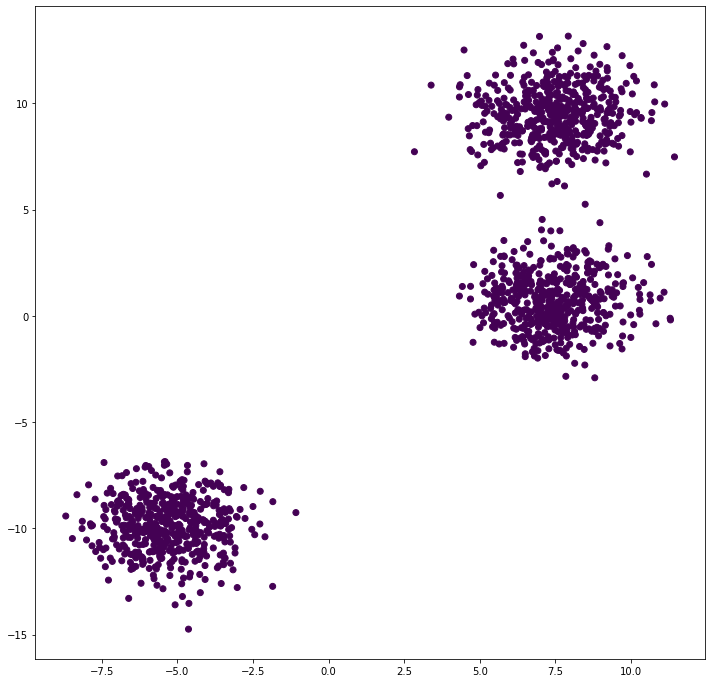

In [136]:
bx,_ =  datasets.make_blobs(n_samples=1530, random_state=8, cluster_std=1.3) 

cl3 = HC(alpha=1.05)#HierarchicalClustering(alpha=1., debug=1,max_iteration=100,delta=.5)
by = cl3.fit(bx)
draw(bx,by)

[  28  263  361  561  567  857  969 1023 1090 1212 1225 1528]


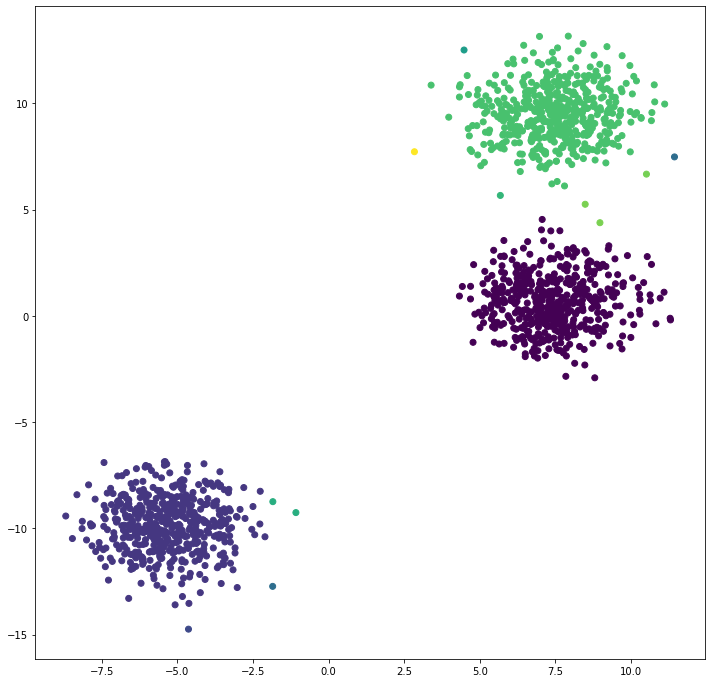

In [141]:
n = -4
#print(cl3._c_all[n])
print(np.unique(cl3._c_all[n]))
draw(bx,cl3._c_all[n])

[121 209]
[209 121]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

[111 232]
[232 111]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 21

[122 321]
[321 122]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 21

[  9 403]
[403   9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 218

[142 159]
[159 142]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 218

[ 43 471]
[471  43]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 143, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 218

[338 394]
[394 338]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 64, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 143, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 218,

[354 375]
[375 354]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 64, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 143, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 218,

[150 211]
[211 150]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 340, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 64, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 143, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 212, 213, 214, 215, 216, 217, 218

[  2 281]
[281   2]
[1, 2, 64, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 340, 97, 98, 99, 100, 101, 102, 103, 104, 110, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 64, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 143, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 115, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 86, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 122, 211, 151, 213, 214, 215, 216, 217, 21

[  9 332]
[332   9]
[1, 2, 64, 4, 5, 6, 7, 8, 9, 288, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 247, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 19, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 54, 220, 2, 78, 273, 80, 81, 82, 83, 30, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 340, 97, 54, 99, 93, 101, 102, 103, 104, 110, 106, 107, 108, 109, 110, 111, 112, 113, 114, 83, 70, 113, 118, 175, 120, 25, 122, 123, 124, 125, 85, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 44, 138, 139, 140, 122, 64, 143, 144, 125, 54, 147, 148, 149, 25, 151, 152, 153, 154, 143, 156, 157, 148, 159, 143, 161, 162, 163, 25, 81, 166, 167, 168, 107, 162, 171, 143, 173, 54, 175, 176, 177, 178, 83, 180, 181, 182, 183, 184, 106, 186, 139, 188, 189, 190, 191, 86, 193, 194, 195, 196, 83, 198, 199, 200, 201, 202, 154, 204, 205, 206, 207, 208, 209, 122, 211, 151, 213, 214, 215, 216, 217, 218, 219, 22

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 

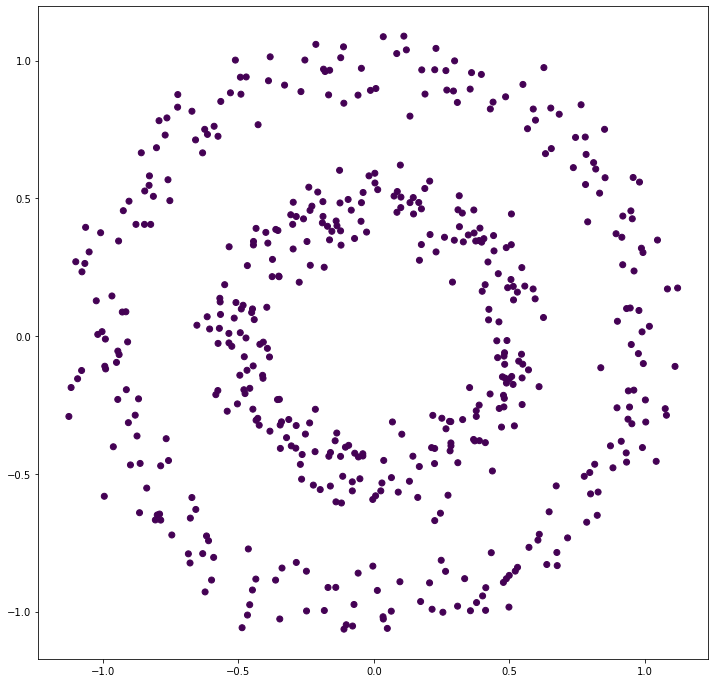

In [150]:
bx,by = datasets.make_circles(n_samples=500, factor=.5, noise=.07) 
cl31 = HC(alpha=1.00, debug=1,max_iteration=100,delta=.05)
by = cl31.fit(bx)
draw(bx,by)

[  8  14  16  24  25  26  27  36  48  50 161]


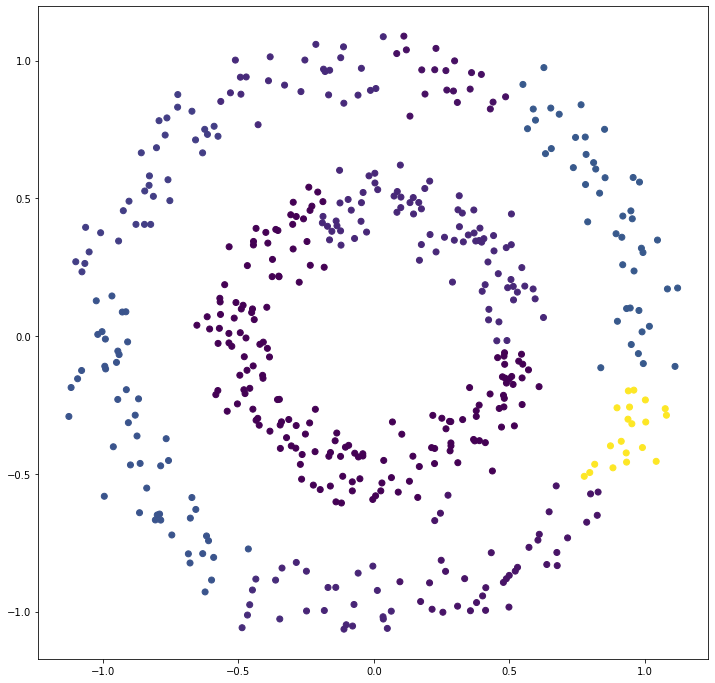

In [151]:
n = -2
#print(cl3._c_all[n])
print(np.unique(cl31._c_all[n]))
draw(bx,cl31._c_all[n])

### fetch_20newsgroups

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
data_test = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42)
print('data loaded')

data loaded


In [4]:
y_train, y_test = data_train.target, data_test.target

In [7]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [10]:
%%time
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

CPU times: user 6.38 s, sys: 16 ms, total: 6.4 s
Wall time: 6.41 s


In [13]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=100): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(x) 
    return x1 

In [14]:
%%time
X_train_ = encode_svd(X_train)

CPU times: user 3min 6s, sys: 1min 36s, total: 4min 43s
Wall time: 2min 55s


In [15]:
print(X_train_.shape)

(11314, 100)


In [46]:
# TODO sklearn.metrics. cos test!!!

In [48]:
###

In [6]:
 
A1 = np.array([
    [0.982772, 0.376789,0.176096,0.185309,0.180585,0.066007,0.171831,0.012917], 
    [0.982772, 0.376789, 0.176096, 0.185309 ,0.180585 ,0.066007 ,0.171831 ,0.012917],
    [0.982772, 0.376789,0.176096,0.185309,0.180585,0.066007,0.171831,0.012917],
    [0.982772, 0.376789,0.176096,0.185309,0.180585,0.066007,0.171831,0.012917],  
    [0.982772,0.376789 ,0.176096 ,0.185309,0.180585,0.066007,0.171831,0.012917]
])
A2 = np.array([
    [0.984338,0.467409,0.169374,0.189054,0.178674,0.052887,0.169602,0.345301],
    [0.986688, 0.476948,0.115043,0.166771,0.136160,0.001436,0.125191,0.153431],
    [0.990603,0.429253,0.177958,0.220205,0.196840,0.061198,0.187378,0.061084],
    [0.989037,0.310016,0.177226,0.199068,0.187513,0.044096,0.178510,0.019783],
    [0.989037,0.276630,0.144016,0.159553,0.151387,0.037046,0.142037,0.011656]
])
A3 = np.array([
    [0.981989,0.419714,0.169247,0.187106,0.177729,0.058492,0.168691,0.310419],
    [0.991386,0.410175,0.125168,0.162897,0.141562,0.013601,0.131270,0.130096],
    [0.991386,0.422893,0.109823,0.157332,0.129353,-0.007105,0.118373,0.097300],
    [0.991386,0.337043,0.146196,0.174445,0.159076,0.017017,0.149379,0.019637],
    [0.989820,0.275040,0.128028,0.146114,0.136475,0.030079,0.126803,0.012542]
])

A4 = np.array([
    [0.983555,0.376789,0.167232,0.185275,0.175792,0.058084,0.166720,0.488023],
    [0.982772,0.435612,0.065085,0.201967,0.098445,0.009293,0.083275,0.172452],
    [0.986688,0.432432,0.034193,0.204036,0.058570,0.004121,0.041016,0.608160],
    [0.985121,0.352941,0.013261,0.160739,0.024501,-0.003402,0.010527,0.875388],
    [0.983555,0.308426,0.006901,0.184096,0.013303,-0.001016,0.000226,0.969398]
])

A5 = np.array([
    [0.934221,0.143084,0.013787,0.017132,0.015279,0.000419,0.004568,0.730702],
    [0.939702,0.163752,0.014702,0.017661,0.016046,0.000697,0.005549,0.716658],
    [0.938136,0.135135,0.016108,0.020480,0.018033,0.000273,0.007072,0.737421],
    [0.948316,0.151033,0.014269,0.016401,0.015261,0.000103,0.005376,0.703300],
    [0.957713,0.144674,0.014664,0.016800,0.015660,0.000518,0.005393,0.697546]
])

A6 = np.array([
    [0.949883, 0.108108,0.017042,0.018846,0.017899,-0.001035,0.007740,0.688593],
    [0.876273,0.171701,0.017993,0.019235,0.018594,-0.000362,0.008794,0.698397],
    [0.212216,0.211447,0.008828,0.141528,0.016620,-0.002720,0.002747,0.991679],
    [0.975724,0.170111,0.018358,0.019102,0.018723,0.000780,0.008509,0.686397],
    [0.96711, 0.162162,0.015358,0.016534,0.015924,0.000189,0.005224,0.690189]
])




    


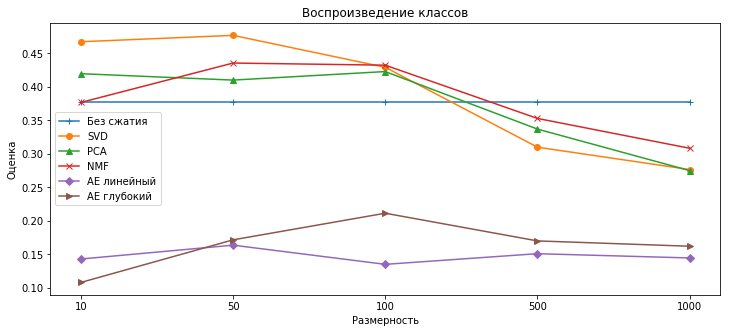

In [44]:
def draw_plot_score(n=1): 
    titles = ['', 'Воспроизведение классов','Однородность','Полнота','V- мера', 'ARI', 'AMI','Силуэт']
    title = titles[n]
    plt.rcParams["figure.figsize"] = (12,5)
    x = ['10','50','100','500','1000']
    plt.plot(x,A1[:,n], label='Без сжатия', marker='+', linestyle='-')
    plt.plot(x,A2[:,n], label='SVD', marker='o', linestyle='-')
    plt.plot(x,A3[:,n], label='PCA', marker='^', linestyle='-')
    plt.plot(x,A4[:,n], label='NMF', marker='x', linestyle='-')
    plt.plot(x,A5[:,n], label='AE линейный', marker='D', linestyle='-')
    plt.plot(x,A6[:,n], label='AE глубокий', marker='>')
    plt.xlabel('Размерность')
    plt.ylabel('Оценка')
    plt.legend()
    plt.title(title)
    
draw_plot_score(1)    

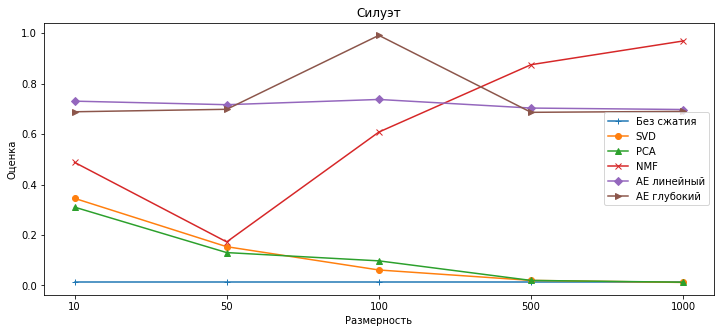

In [50]:
draw_plot_score(7) 

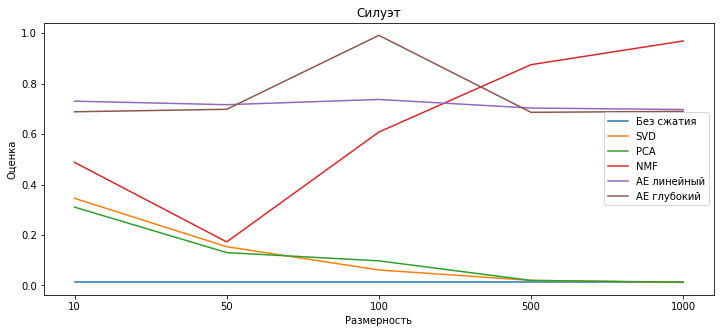

In [18]:
draw_plot_score(7, 'Силуэт')  

In [41]:
?plt.plot